On définit le jour 25/01 comme le jour 0. Alors, on a :

|date|jour|
|---|---|
|25/01|0|
|24/02|30|
|15/03|50|

In [1]:
import numpy as np
from scipy.integrate import solve_ivp 
import matplotlib.pyplot as plt
np.random.seed(0)

### Question 1

In [2]:
COLORS_PLOT=['grey','blue','orange','red','black']

class SEIR():
    def __init__(self, params=None):
        d0 = np.datetime64('2020-01-25')
        self.T_end = np.datetime64("2020-05-11")
        self.d0 = d0
        S0=67e6
        self.S0 = S0
        self.reset(params)
    
    def reset(self, params=None):
        if params is not None:
            x = params
            # Probability for different evenements
            self.p_a = x[0]
            self.p_IH = x[1]
            self.p_IU = x[2]
            self.p_HD = x[3]
            self.p_HU = x[4]
            self.p_UD = x[5]

            # number of days passed in different phase
            self.N_I = x[6]
            self.N_H = x[7]
            self.N_U = x[8]

            self.R0 = x[9]       # Reproduction rate of coronavirus
            self.mu = x[10]      # Decline rate of transmission
            self.N = x[11]          # The beginning date of the quarantine

            self.t0 = x[12]          # The beginning date of the epidemie
            self.I_minus = x[13]     # The number of infected person at the beginning
            self.lamb1 = x[14]   # positive rate for the test 1 in the differentiel equation
            self.lamb2 = 0
        else:
        #########################################################################
        ############## We reset the variables with the uniform law ##############
        #########################################################################
        # Probability for different evenements
            self.p_a = np.random.uniform(0.4, 0.9)
            self.p_IH = np.random.uniform(0.05, 0.2)
            self.p_IU = np.random.uniform(0.01, 0.04)
            self.p_HD = np.random.uniform(0.1, 0.2)
            self.p_HU = np.random.uniform(0.1, 0.2)
            self.p_UD = np.random.uniform(0.2, 0.4)

            # number of days passed in different phase
            self.N_I = np.random.uniform(8, 12)
            self.N_H = np.random.uniform(15, 25)
            self.N_U = np.random.uniform(10, 20)


            self.R0 = np.random.uniform(2.9, 3.4)        # Reproduction rate of coronavirus
            self.mu = np.random.uniform(0.01, 0.08)      # Decline rate of transmission
            self.N = np.random.randint(30, 50)           # The beginning date of the quarantine

            self.t0 = np.random.randint(0, 31)           # The beginning date of the epidemie
            self.I_minus = np.random.uniform(1, 100)     # The number of infected person at the beginning
            self.lamb1 = np.random.uniform(1e-4, 1e-3)   # positive rate for the test 1 in the differentiel equation
            self.lamb2 = 0                               # positive rate for the test 2 in the differentiel equation

        #########################################################################
        ############ The coefficients in the differentiel equations #############
        #########################################################################
        variables = np.ones(9)

        variables[1] = (self.p_a+(1-self.p_a)*(1-self.p_IH-self.p_IU))/self.N_I          # gamma_IR
        variables[2] = (1-self.p_a)*self.p_IH/self.N_I                    # gamma_IH
        variables[3] = (1-self.p_a)*self.p_IU/self.N_I                    # gamma_IU
        
        variables[4] = self.p_HD/self.N_H                                 # gamma_HD
        variables[5] = self.p_HU/self.N_H                                 # gamma_HU
        variables[6] = (1-self.p_HD-self.p_HU)/self.N_H                   # gamma_HR
        
        variables[7] = self.p_UD/self.N_U                                 # gamma_UD
        variables[8] = (1-self.p_UD)/self.N_U                             # gamma_UR
        
        variables[0] = self.R0*(self.lamb1+variables[1]+variables[2]+variables[3])/self.S0
                                                            # tau0, the transmission rate at the beginning
        
        self.variables = np.copy(variables)
        
        #########################################################################
        ################### Population in different blocs #######################
        #########################################################################
        # We modelize the population with type S, I-, I+, R-, R+I, H, U, R+H, D, DR
        # To a vector.
        self.population = np.zeros(10)
        self.population[0] = self.S0                        # S_0 = 67
        self.population[1] = self.I_minus                   # I- in [1, 100] randomly
        return

    def params(self):
        x = np.array([self.p_a, self.p_IH, self.p_IU,
                     self.p_HD, self.p_HU, self.p_UD,
                     self.N_I, self.N_H, self.N_U,
                     self.R0, self.mu, self.N,
                     self.t0, self.I_minus, self.lamb1])
        return x
    
    def evolution_dt(self, t, population):
        derivee = np.zeros(10)
        
        ####### Initialisation of different variables #######
        # Population
        S, I_minus, I_plus, R_minus, R_I, H, U, R_H, D, DR = population
        # Variables
        (tau0, 
         gamma_IR, gamma_IH, gamma_IU,
         gamma_HD, gamma_HU, gamma_HR, 
         gamma_UD, gamma_UR) = self.variables
        
        # tau at time t
        tau = tau0*np.exp(-self.mu*max(t-self.N, 0))
        
        # dX/dt for X = S, I-, I+, R-, R+I, H, U, R+H, D
        derivee[0] = -tau*S*I_minus                                                 #dS/dt
        derivee[1] = (tau*S - self.lamb1 - (gamma_IR+gamma_IH+gamma_IU))*I_minus         #dI_minus/dt
        derivee[2] = self.lamb1*I_minus - (gamma_IR+gamma_IH+gamma_IU)*I_plus            #dI_plus/dt
        derivee[3] = gamma_IR*I_minus - self.lamb2*R_minus                               #dR_minus/dt
        derivee[4] = gamma_IR*I_plus + self.lamb2*R_minus                                #dR_I/dt
        derivee[5] = gamma_IH*(I_minus+I_plus) - (gamma_HR+gamma_HD+gamma_HU)*H     #dH/dt
        derivee[6] = gamma_IU*(I_minus+I_plus) + gamma_HU*H - (gamma_UR+gamma_UD)*U #dU/dt
        derivee[7] = gamma_HR*H + gamma_UR*U                                        #dR_H
        derivee[8] = gamma_UD*U + gamma_HD*H                                        #dD/dt
        derivee[9] = (self.lamb1+gamma_IH+gamma_IU)*I_minus - DR                         #dDR/dt
        
        return derivee
    
    def evolution_T(self, MODE_DISPLAY=False, T_end=107):
        d0 = self.d0 + np.timedelta64(int(self.t0), 'D')
        if MODE_DISPLAY:
            print("La date du début de l'épidémie: ", d0)
            print("La fin de simulation: ", self.T_end)
        self.solution = solve_ivp(
            fun=self.evolution_dt,
            t_span=(self.t0, T_end+1),
            y0=self.population,
            t_eval=np.arange(self.t0+1, T_end+1),
            dense_output=True,
        )
        self.distribution = self.solution.y
        return self.solution
    
    def soins_intensifs(self):
        SI = self.distribution[6, :]
        date_pic = self.d0 + np.timedelta64(int(self.t0) + np.argmax(SI), 'D')
        nb_maximum = np.max(SI)
        date_maximum = self.t0 + np.argmax(SI)
        return nb_maximum, date_maximum
    
    
    def print_curve(self):
        import matplotlib.pyplot as plt
        sol = model.evolution_T(True)
        nb_maximum, date_maximum = self.soins_intensifs()
        print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
        print("La date où on détecte le plus de patients : {}".format(self.d0 + np.timedelta64(int(date_maximum), 'D')))
        plt.figure(figsize=(17, 10))
        indices = [9, 5, 6, 8, 7]
        labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)", "gueris (R+)"]
        for i in range(5):
            plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i], color=COLORS_PLOT[i])
        plt.axvline(np.datetime64('2020-03-31'), label='end learning date')
        plt.legend(loc="upper left")
        plt.xlabel("date")
        plt.ylabel("nombre")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        
        plt.show()

Test modèle de la question 1

La date du début de l'épidémie:  2020-02-18
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 237.02373047903023
La date où on détecte le plus de patients : 2020-04-12


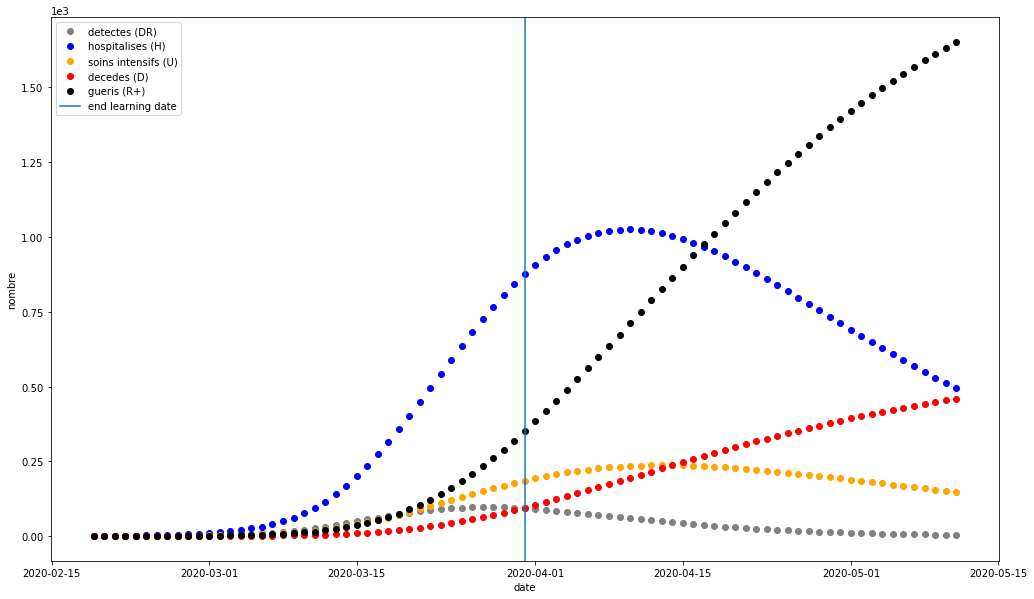

In [3]:
model = SEIR()
model.print_curve()

### Question 2
Méthode de Monte Carlo pour
- la loi du nombre maximal de patients présents en soins intensifs
- la loi de la date du pic de l'épidémie

In [4]:
%%time
M = int(1e3)
model = SEIR()
nb_max_soins_intensifs = np.zeros(M)
date_max_soins_intensifs = np.zeros(M)

for i in range(M):
    model.reset()
    model.evolution_T()
    nb_maximum, date_maximum = model.soins_intensifs()
    nb_max_soins_intensifs[i] = nb_maximum
    date_max_soins_intensifs[i] = date_maximum

#np.save("result/Q2/nb_max_soins_intensifs", nb_max_soins_intensifs)
#np.save("result/Q2/date_max_soins_intensifs", date_max_soins_intensifs)

Wall time: 7.42 s


On définit une fonction pour afficher les deux lois

In [5]:
def num_to_date(num):
    return np.datetime64('2020-01-25') + np.timedelta64(int(num), 'D')
def print_law(tab, title, M, day=False):
    plt.figure()
    plt.title("L'histogramme de\n" + title)
    plt.hist(tab, bins=int(10), density=True)
    plt.show()
    if day:
        transform = num_to_date
    else:
        transform = lambda x : x
    print("La moyenne :\t {}".format(transform(np.mean(tab))))
    print("Quantile à 10% : {}".format(transform(np.quantile(tab, 0.1))))
    print("Quantile à 90% : {}".format(transform(np.quantile(tab, 0.9))))

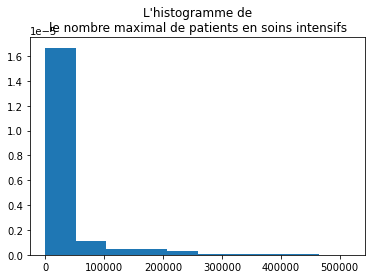

La moyenne :	 26169.619936642648
Quantile à 10% : 30.674927277771282
Quantile à 90% : 82611.51012343152


In [6]:
M = int(1e4)
#nb_max_soins_intensifs = np.load("result/Q2/nb_max_soins_intensifs.npy")
print_law(nb_max_soins_intensifs, "le nombre maximal de patients en soins intensifs", M)

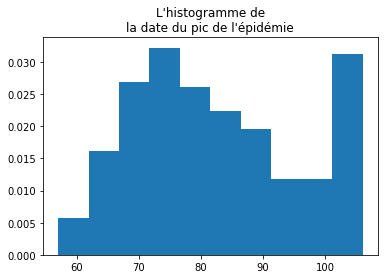

La moyenne :	 2020-04-16
Quantile à 10% : 2020-03-31
Quantile à 90% : 2020-05-10


In [7]:
#date_max_soins_intensifs = np.load("result/Q2/date_max_soins_intensifs.npy")
print_law(date_max_soins_intensifs, "la date du pic de l'épidémie", M, True)

### Question 3

Analyse de sensibilité pour les deux variables de sortie de la question précédente avec la méthode de Morris.

Pour chaque entrée, on prend 0.01 * la taille de borne de la loi uniforme pour $\delta$

In [8]:
%%time
# DIAG_INTERVAL : the size of the uniform law
DIAG_INTERVAL=np.array([0.5, 0.15, 0.03, 0.1, 0.1,0.2,4.,10.,10.,0.5,0.07,19.,30.,99.,1e-3 - 1e-4])
# bounds
bounds=[(0.4,0.9),
       (0.05,0.2),
       (0.01,0.04),
       (0.1,0.2),
       (0.1,0.2),
       (0.2,0.4),
       (8.,12.),
       (15.,25.),
       (10.,20.),
       (2.9,3.4),
       (0.01,0.08),
       (30,49),
       (0.,30),
       (1.,100.),
       (1e-4, 1e-3)]

# R : Nb of samples for Morris method
R = int(1e2)

# delta : the coefficient multiplied by DIAG_INTERVAL
delta = 1e-2
model = SEIR()
S_nb_maximum = np.zeros(shape=(R, 15))
S_date_maximum = np.zeros(shape=(R, 15))

for i in range(R):
    #print(i)
    model.reset()
    model.evolution_T()
    nb_maximum, date_maximum = model.soins_intensifs()
    params = np.copy(model.params())

    for j in range(15):
        params_bis = np.copy(params)
        if j in [11, 12]:
            delta_bis = 1
        else:
            delta_bis = delta * DIAG_INTERVAL[j]
        if params_bis[j] + delta_bis > bounds[j][1]:
            coeff = -1
        else:
            coeff = 1
        params_bis[j] += coeff * delta_bis
        #print(j, params_bis)
        model.reset(params_bis)
        model.evolution_T()
        nb_maximum_bis, date_maximum_bis = model.soins_intensifs()

        S_nb_maximum[i][j] = (nb_maximum - nb_maximum_bis) / coeff / delta_bis
        S_date_maximum[i][j] = (date_maximum - date_maximum_bis) / coeff / delta_bis

#np.save("result/Q3/S_nb_maximum", S_nb_maximum)
#np.save("result/Q3/S_date_maximum", S_date_maximum)

Wall time: 11.6 s


In [9]:
def print_parameters(S):
    names = ["p_a", "p_IH", "p_IU", 
             "p_HD", "p_HU", "p_UD", 
             "N_I", "N_H", "N_U", 
             "R0", "mu", "N",
            "t0", "I-", "lamb1"]
    mu_S = np.abs(S).mean(axis=0)
    sigma_S = S.std(axis=0, ddof=1)
    for i in range(15):
        print(names[i] + 
              "\t mean_S : " + 
              "{0:5.3f}".format(mu_S[i]) + 
              ", \t sigma_S : {0:5.3f}".format(sigma_S[i]) +
              ", \t rapport sigma/mu: {0:5.3f}".format(sigma_S[i]/mu_S[i]))

Nous normalisons aussi les S par rapport à la moyenne de sortie : cela nous permettra de mieux identifier les variables influentes

In [10]:
#S_nb_maximum = np.load("result/Q3/S_nb_maximum.npy") / nb_max_soins_intensifs.mean()
S_nb_maximum /= nb_max_soins_intensifs.mean()
print_parameters(S_nb_maximum)

p_a	 mean_S : 2.973, 	 sigma_S : 6.161, 	 rapport sigma/mu: 2.072
p_IH	 mean_S : 3.174, 	 sigma_S : 7.103, 	 rapport sigma/mu: 2.238
p_IU	 mean_S : 34.123, 	 sigma_S : 70.123, 	 rapport sigma/mu: 2.055
p_HD	 mean_S : 0.000, 	 sigma_S : 0.000, 	 rapport sigma/mu: 3.146
p_HU	 mean_S : 2.494, 	 sigma_S : 6.494, 	 rapport sigma/mu: 2.603
p_UD	 mean_S : 0.000, 	 sigma_S : 0.000, 	 rapport sigma/mu: 3.322
N_I	 mean_S : 0.648, 	 sigma_S : 1.121, 	 rapport sigma/mu: 1.730
N_H	 mean_S : 0.010, 	 sigma_S : 0.025, 	 rapport sigma/mu: 2.620
N_U	 mean_S : 0.053, 	 sigma_S : 0.119, 	 rapport sigma/mu: 2.245
R0	 mean_S : 2.899, 	 sigma_S : 4.809, 	 rapport sigma/mu: 1.659
mu	 mean_S : 62.917, 	 sigma_S : 166.966, 	 rapport sigma/mu: 2.654
N	 mean_S : 0.109, 	 sigma_S : 0.182, 	 rapport sigma/mu: 1.661
t0	 mean_S : 0.106, 	 sigma_S : 0.180, 	 rapport sigma/mu: 1.691
I-	 mean_S : 0.014, 	 sigma_S : 0.027, 	 rapport sigma/mu: 1.949
lamb1	 mean_S : 54.612, 	 sigma_S : 88.301, 	 rapport sigma/mu: 1.617


Pour le nombre maximal de patients présents en soins intensifs, nous classons les entrées en trois groupes:
 - groupe avec effets négligeables : $p_{HD}, p_{UD}, N_H, I_0^-$
 - groupe avec effets linéaires et sans interaction : $N_U, N, t_0$
 - groupe avec effets non linéaires et/ou avec interaction : $p_a, p_{IH}, p_{IU}, p_{HU}, N_I, R_0, \mu, \lambda_1$


In [11]:
#S_date_maximum = np.load("result/Q3/S_date_maximum.npy") / date_max_soins_intensifs
S_date_maximum /= date_max_soins_intensifs.mean()
print_parameters(S_date_maximum)

p_a	 mean_S : 0.000, 	 sigma_S : 0.000, 	 rapport sigma/mu:   nan
p_IH	 mean_S : 0.564, 	 sigma_S : 2.066, 	 rapport sigma/mu: 3.663
p_IU	 mean_S : 1.611, 	 sigma_S : 7.934, 	 rapport sigma/mu: 4.924
p_HD	 mean_S : 0.000, 	 sigma_S : 0.000, 	 rapport sigma/mu:   nan
p_HU	 mean_S : 0.483, 	 sigma_S : 2.380, 	 rapport sigma/mu: 4.924
p_UD	 mean_S : 0.000, 	 sigma_S : 0.000, 	 rapport sigma/mu:   nan
N_I	 mean_S : 0.030, 	 sigma_S : 0.091, 	 rapport sigma/mu: 3.015
N_H	 mean_S : 0.001, 	 sigma_S : 0.012, 	 rapport sigma/mu: 10.000
N_U	 mean_S : 0.008, 	 sigma_S : 0.031, 	 rapport sigma/mu: 3.663
R0	 mean_S : 0.193, 	 sigma_S : 0.687, 	 rapport sigma/mu: 3.553
mu	 mean_S : 5.352, 	 sigma_S : 8.450, 	 rapport sigma/mu: 1.579
N	 mean_S : 0.009, 	 sigma_S : 0.007, 	 rapport sigma/mu: 0.783
t0	 mean_S : 0.004, 	 sigma_S : 0.007, 	 rapport sigma/mu: 1.978
I-	 mean_S : 0.000, 	 sigma_S : 0.002, 	 rapport sigma/mu: 4.924
lamb1	 mean_S : 0.000, 	 sigma_S : 0.000, 	 rapport sigma/mu:   nan


C:\Users\maxen\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


Pour la date du pic de l'épidémie, nous classons les entrées en trois groupes:
 - groupe avec effets négligeables : $p_a, p_{HD}, p_{UD}, N_H, N_U, t_0, I_0^-, \lambda_1$
 - groupe avec effets linéaires et sans interaction : $N, N_I$
 - groupe avec effets non linéaires et/ou avec interaction : $p_{IH}, p_{IU}, p_{HU}, R_0, \mu$

$\lambda_1$ a une variance petite mais le rapport moyenne/$\sigma$ reste très grand.


### Question 4

In [12]:
%%time
np.random.seed(0)
# n : Nb of samples for Sobel method
n = 100

model = SEIR()
# The result with the samples X^k
f_nb_maximum = np.zeros(shape=(n, 1))
f_date_maximum = np.zeros(shape=(n, 1))

# The 15 results with the samples tilde(X)^k at j th places
# first order
f_first_order_nb_maximum = np.zeros(shape=(n, 15))
f_first_order_date_maximum = np.zeros(shape=(n, 15))

# total index
f_total_index_nb_maximum = np.zeros(shape=(n, 15))
f_total_index_date_maximum = np.zeros(shape=(n, 15))

# Monte Carlo estimation
for i in range(n):
    model.reset()
    model.evolution_T()
    nb_maximum, date_maximum = model.soins_intensifs()
    f_nb_maximum[i] = nb_maximum
    f_date_maximum[i] = date_maximum
    params = np.copy(model.params())

    # Get tilde(X)
    model.reset()
    params_bis = np.copy(model.params())
    for j in range(15):
        ########### first order ###########
        params_first_order = np.copy(params_bis)
        params_first_order[j] = params[j]
        model.reset(params_first_order)
        
        # Get the result
        model.evolution_T()
        nb_maximum_bis_first, date_maximum_bis_first = model.soins_intensifs()
        f_first_order_nb_maximum[i][j] = nb_maximum_bis_first
        f_first_order_date_maximum[i][j] = date_maximum_bis_first

        ########### total index ###########
        # Get params from the original one, then replace one of them with random law
        params_total_index = np.copy(params)
        params_total_index[j] = params_bis[j]
        model.reset(params_total_index)
        
        # Get the result
        model.evolution_T()
        nb_maximum_bis_total, date_maximum_bis_total = model.soins_intensifs()
        f_total_index_nb_maximum[i][j] = nb_maximum_bis_total
        f_total_index_date_maximum[i][j] = date_maximum_bis_total

#np.save("result/Q4/f_nb_maximum", f_nb_maximum)
#np.save("result/Q4/f_date_maximum", f_date_maximum)
#np.save("result/Q4/f_first_order_nb_maximum", f_first_order_nb_maximum)
#np.save("result/Q4/f_first_order_date_maximum", f_first_order_date_maximum)
#np.save("result/Q4/f_total_index_nb_maximum", f_total_index_nb_maximum)
#np.save("result/Q4/f_total_index_date_maximum", f_total_index_date_maximum)

Wall time: 23.3 s


In [13]:
def sobel_index(f, f_tilde_first, f_tilde_total):
    names = ["p_a", "p_IH", "p_IU", 
             "p_HD", "p_HU", "p_UD", 
             "N_I", "N_H", "N_U", 
             "R0", "mu", "N",
             "t0", "I-", "lamb1"]
    #f = f.reshape(f.shape[0], -1)
    # f_0 estimation
    f_0 = f.mean()

    # D estimation
    D = (f * f).mean() - f_0*f_0
    
    # D_i estimation
    Di = (f * f_tilde_first).mean(axis=0) - (f_0*f_0)
    Si = Di / D
    
    # D_T_i estimation
    D_Ti = ((f - f_tilde_total) ** 2).mean(axis=0) / 2
    S_Ti = D_Ti / D
    
    for i in range(15):
        print(names[i] + "\t : S_i = {0:3.4f}, \tS_Ti = ".format(Si[i]) + "{0:3.3f}".format(S_Ti[i]))
    #return Si, S_Ti

On compare les valeurs à $\frac{1}{15}$ (contribution "normale" de chaque variable).

In [14]:
sobel_index(f_nb_maximum, f_first_order_nb_maximum, f_total_index_nb_maximum)

p_a	 : S_i = 0.1162, 	S_Ti = 0.205
p_IH	 : S_i = 0.1192, 	S_Ti = 0.015
p_IU	 : S_i = 0.1090, 	S_Ti = 0.047
p_HD	 : S_i = 0.0839, 	S_Ti = 0.000
p_HU	 : S_i = 0.0771, 	S_Ti = 0.007
p_UD	 : S_i = 0.0839, 	S_Ti = 0.000
N_I	 : S_i = 0.3234, 	S_Ti = 0.205
N_H	 : S_i = 0.0897, 	S_Ti = 0.001
N_U	 : S_i = 0.0457, 	S_Ti = 0.033
R0	 : S_i = 0.1137, 	S_Ti = 0.082
mu	 : S_i = 0.3382, 	S_Ti = 0.170
N	 : S_i = 0.2493, 	S_Ti = 0.320
t0	 : S_i = 0.0569, 	S_Ti = 0.372
I-	 : S_i = 0.1233, 	S_Ti = 0.039
lamb1	 : S_i = 0.0843, 	S_Ti = 0.000


Pour le nombre maximal de patients présents en soins intensifs, nous classons les entrées en trois groupes:
 - groupe avec effets négligeables ($S_{T_i}$ petit) : $p_{HD}, p_{HU}, p_{UD}, N_H, N_U, \lambda_1$
 - groupe avec effets importants ($S_i$ grand): $p_{IH}, p_{IU}, N_I, R_0, \mu, I_0^-$
 - groupe avec effets importants en interaction : $p_a, N, t_0$

In [15]:
sobel_index(f_date_maximum, f_first_order_date_maximum, f_total_index_date_maximum)

p_a	 : S_i = 0.1960, 	S_Ti = 0.000
p_IH	 : S_i = 0.1699, 	S_Ti = 0.009
p_IU	 : S_i = 0.1983, 	S_Ti = 0.009
p_HD	 : S_i = 0.1960, 	S_Ti = 0.000
p_HU	 : S_i = 0.1841, 	S_Ti = 0.003
p_UD	 : S_i = 0.1960, 	S_Ti = 0.000
N_I	 : S_i = -0.0360, 	S_Ti = 0.042
N_H	 : S_i = 0.2038, 	S_Ti = 0.000
N_U	 : S_i = 0.2376, 	S_Ti = 0.013
R0	 : S_i = 0.2138, 	S_Ti = 0.013
mu	 : S_i = 1.6583, 	S_Ti = 0.793
N	 : S_i = -0.2984, 	S_Ti = 0.118
t0	 : S_i = 0.1539, 	S_Ti = 0.077
I-	 : S_i = 0.2731, 	S_Ti = 0.005
lamb1	 : S_i = 0.1938, 	S_Ti = 0.000


Pour la date du pic de l'épidémie, nous classons les entrées en trois groupes:
 - groupe avec effets négligeables ($S_{T_i}$ petit) : $N_I$
 - groupe avec effets importants ($S_i$ grand): $p_a, p_{IH}, p_{IU}, p_{HD}, p_{HU}, p_{UD}, N_H, N_U, R_0, N, t_0, I_0^-, \lambda_1$
 - groupe avec effets importants en interaction : $\mu$

### Question 5

In [16]:
%%time
np.random.seed(0)
indices = np.array([5,6,8,7]) # Read in order H U D R+H
# n : Nb of samples for Sobel method
n = int(1e2)

model = SEIR()
# The result with the samples X^k
f = np.zeros(shape=(n, 4, 76))

# The 15 results with the samples tilde(X)^k at j th places
# first order
f_first_order = np.zeros(shape=(n, 15, 4, 76))

# total index
f_total_index = np.zeros(shape=(n,15,4, 76))

# Monte Carlo estimation
for i in range(n):
    model.reset()
    model.evolution_T()
    f[i] = np.copy(model.distribution[indices, -76:])
    params = np.copy(model.params())

    # Get tilde(X)
    model.reset()
    params_bis = np.copy(model.params())
    for j in range(15):
        ########### first order ###########
        params_first_order = np.copy(params_bis)
        params_first_order[j] = params[j]
        model.reset(params_first_order)
        
        # Get the result
        model.evolution_T()
        f_first_order[i][j] = model.distribution[indices, -76:]

    ########### total index ###########
        # Get params from the original one, then replace one of them with random law
        params_total_index = np.copy(params)
        params_total_index[j] = params_bis[j]
        model.reset(params_total_index)
        
        # Get the result
        model.evolution_T()
        f_total_index[i][j] = model.distribution[indices, -76:]

#np.save("result/Q5/f", f)
#np.save("result/Q5/f_first_order", f_first_order)
#np.save("result/Q5/f_total_index", f_total_index)

Wall time: 21.2 s


In [17]:
def sobel_index_by_date(f, f_tilde_first, f_tilde_total):
    names = ["p_a", "p_IH", "p_IU", 
             "p_HD", "p_HU", "p_UD", 
             "N_I", "N_H", "N_U", 
             "R0", "mu", "N",
             "t0", "I-", "lamb1"]
    #print(f.shape, f_tilde_first.shape, f_tilde_total.shape)
    # f_0 estimation
    f_0 = f.mean(axis=0)

    # D estimation
    D = (f * f).mean(axis=0) - f_0*f_0
    
    # D_i estimation
    Di = []
    for i in range(15):
        Di.append((f * f_tilde_first[:, i, :]).mean(axis=0) - (f_0 * f_0))
    Si = [Di[i] / D for i in range(15)]
    
    # D_T_i estimation
    D_Ti = []
    for i in range(15):
        D_Ti.append(((f - f_tilde_total[:, i, :]) ** 2).mean(axis=0) / 2)
    S_Ti = [D_Ti[i] / D for i in range(15)]
    
    fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(10,10))
    for i in range(15):
        ax[i%5][i//5].plot(Si[i], label=names[i] + " Si")
        ax[i%5][i//5].plot(S_Ti[i], label=names[i] + " S_Ti")
        ax[i%5][i//5].legend()
    #return Si, S_Ti

#### Evaluation H

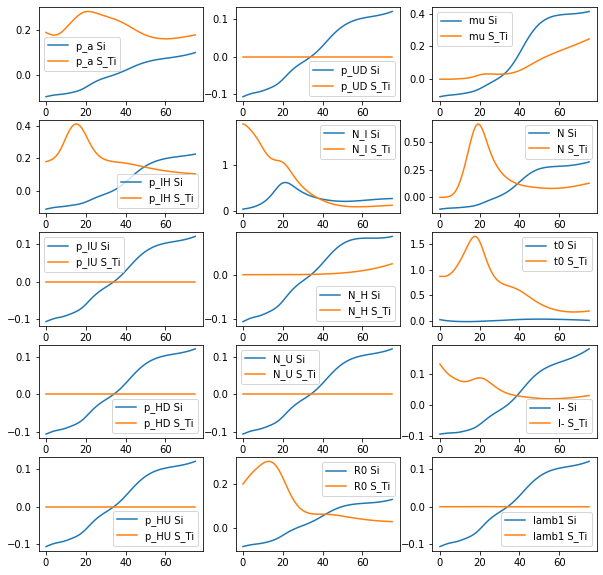

In [18]:
#H
i = 0
sobel_index_by_date(f[:, i], f_first_order[:, :, i], f_total_index[:, :, i])

Pour les valeurs considérées $p_a, N_I, R_0, \mu, N, t_0, I_0^-$, on a
 - $p_a$ : effets importants en interaction.
 - $N_I$ : effets importants en interaction au début. Beaucoup moins important vers la fin.
 - $R_0$ : Comme $N_I$, mais moins important.
 - $\mu$ : effets de plus en plus importants au cours du temps.
 - $N$ : effets très important en interaction vers la fin mars.
 - $t_0$ : effets très importants en interaction au début (24/02) et toujours non négligeables vers la fin.
 - $I_0^-$ : Comme $t_0$, mais beaucoup moins important.

#### Evaluation U

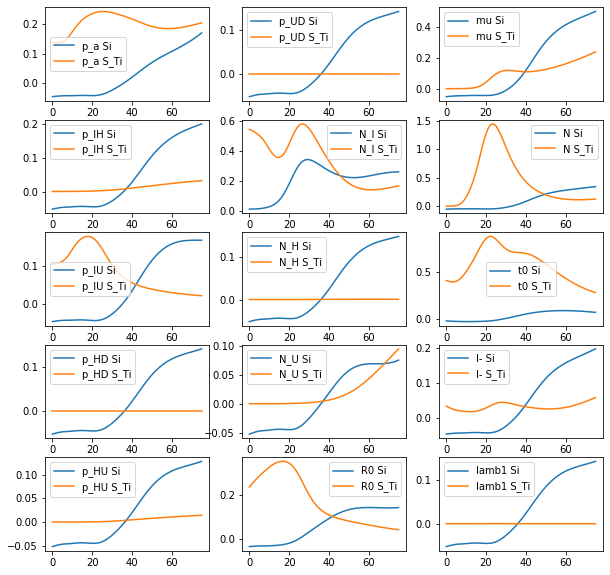

In [19]:
#U
i = 1
sobel_index_by_date(f[:, i], f_first_order[:, :, i], f_total_index[:, :, i])

 - $p_a$ : effets importants en interaction.
 - $N_I$ : effets importants en interaction avec un pic vers le 10 mars.
 - $R_0$ : Comme $N_I$, mais moins important.
 - $\mu$ : effets importants en interaction avec l'effet propre vers la fin (le 11 mai).
 - $N$ : effets négligeables au début mais importants en interaction à partir du 15 mars, avec un pic vers le 10 mars.
 - $t_0$ : effets très importants au 10 mars et toujours non négligeables vers la fin.
 - $I_0^-$ : effet propre important.

#### Evaluation D

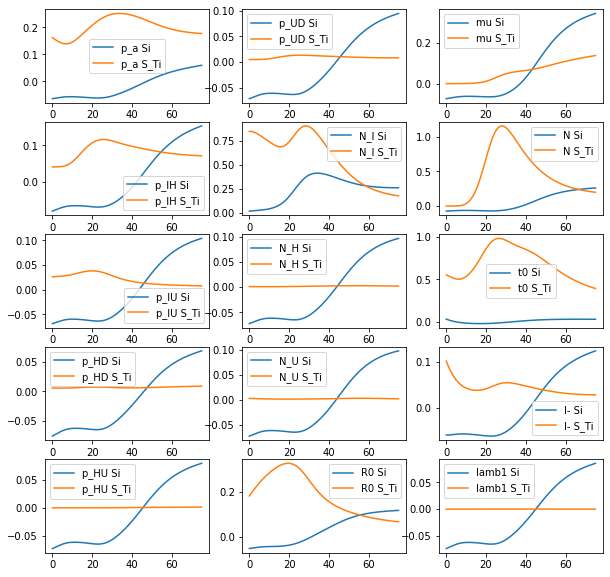

In [20]:
#D
i = 2
sobel_index_by_date(f[:, i], f_first_order[:, :, i], f_total_index[:, :, i])

 - $p_a$ : effets importants en interaction.
 - $N_I$ : effets importants en interaction avec un pic vers le 15 mars.
 - $R_0$ : comme $N_I$, mais moins important.
 - $\mu$ : effets négligeable au début mais en interaction avec les autres variables et un effet propre à l a fin.
 - $N$ : effets très importants en interaction vers le 15 mars.
 - $t_0$ : Comme N.
 - $I_0^-$ :effets négligeables.

#### Evaluation $R^{+H}$

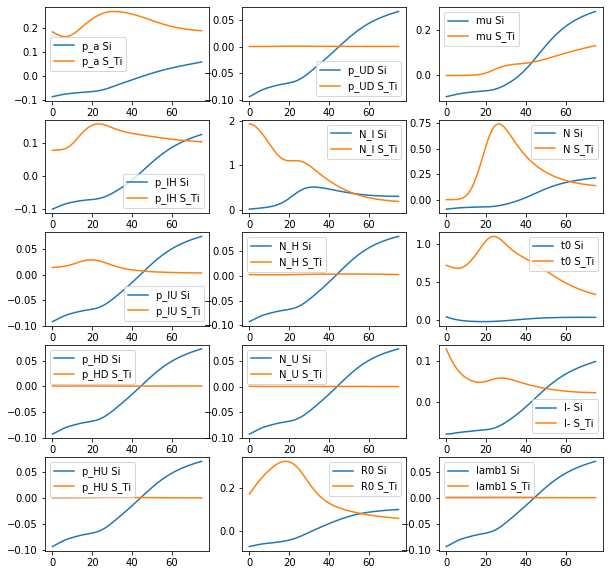

In [21]:
#R+H
i = 3
sobel_index_by_date(f[:, i], f_first_order[:, :, i], f_total_index[:, :, i])

 - $p_a$ : effets importants en interaction.
 - $N_I$ : effets importants en interaction avec un pic au début.
 - $R_0$ : effets en interaction avec un pic le début mars.
 - $\mu$ : effets négligeables au début et importants en interaction avec les autre variables plus ses effets propres à la fin.
 - $N$ : comme $R_0$, mais beaucoup plus important.
 - $t_0$ : comme $N$, mais encore plus important
 - $I_0^-$ : effets négligeables.

### Question 6

In [22]:
import pandas as pd

In [23]:
data_nb_cumule = pd.read_csv("data/nb_contamination_cumul.csv")
data_hospital = pd.read_csv("data/data_hospital.csv", sep=";")

On trouve que nb_contamination_cumul inclut les données du 21/02/2020 au 27/02/2021.

In [24]:
print(data_nb_cumule.head(5))
print(data_nb_cumule.tail(5))

    date  nbre
0  21/02    12
1  22/02    12
2  23/02    12
3  24/02    12
4  25/02    14
      date     nbre
355  23/02  3629891
356  24/02  3661410
357  25/02  3686813
358  26/02  3712020
359  27/02  3736016


Les données de data_hospital inclut aussi les departements et sexes.

In [25]:
data_hospital.head(5)

dep  sexe        jour  hosp  rea  rad  dc
0  01     0  2020-03-18     2    0    1   0
1  01     1  2020-03-18     1    0    1   0
2  01     2  2020-03-18     1    0    0   0
3  02     0  2020-03-18    41   10   18  11
4  02     1  2020-03-18    19    4   11   6

In [26]:
# Pre-treatment of data_hospital : We add up all the cases with the same date(jour)
data_hospital = data_hospital.groupby(by="jour").sum().drop('sexe', axis=1)
data_hospital = data_hospital.reset_index()

# Pre-treatment : We change to the difference (number of cases detected of each day)
data_nb_cumule.nbre = data_nb_cumule.nbre.diff()

# Change the date's format
data_nb_cumule = data_nb_cumule[:100]     # in data_nb_cumule, there are data until 25/02/2021 without
                                          # precision on year. We take the first 100 rows in this case.
data_nb_cumule.date = pd.to_datetime(data_nb_cumule.date + "/20", format="%d/%m/%y")
data_hospital.jour = pd.to_datetime(data_hospital.jour, format="20%y-%m-%d")

# We only want the data until May 11
data_nb_cumule = data_nb_cumule[data_nb_cumule.date < "2020-05-11"]
data_hospital = data_hospital[data_hospital.jour < "2020-05-11"]

# Rename the jour column of data_hospital to date
data_hospital = data_hospital.rename({"jour": "date"}, axis=1)

#### Visualisation

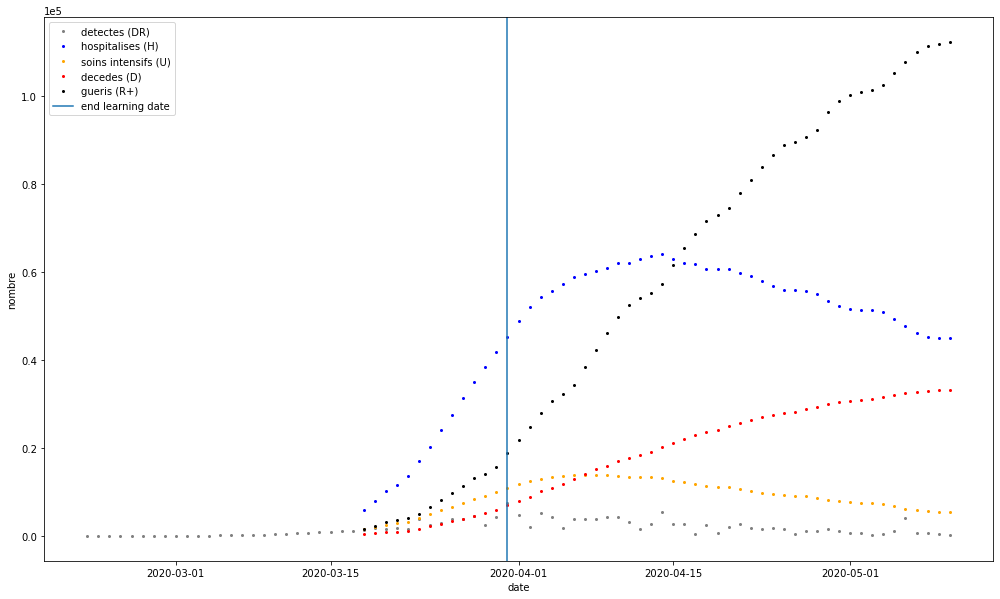

In [27]:
COLORS_PLOT=['grey','blue','orange','red','black']
plt.figure(figsize=(17, 10))
plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2, color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.plot_date(data_hospital.date, data_hospital.rad, label='gueris (R+)', markersize=2,color=COLORS_PLOT[4])
plt.axvline(np.datetime64('2020-03-31'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.show()

### Question 7

On minimise l'erreur avec chaque date possible (la fonction minimize ne permet pas d'appliquer au cas où certaines variables sont discrètes).

In [28]:
from scipy.optimize import minimize

data_DR = data_nb_cumule.nbre
data_H = data_hospital.hosp
data_U = data_hospital.rea
data_D = data_hospital.dc
data_R = data_hospital.rad

def error_local(data,pred):
    ## Return sum(f(x, data_i)**2)
    err=(pred-data)/np.sqrt(pred)
    return np.sum(err**2)

def meta_error(x, date_end, x11, x12, T_end):
    ## Calculate error at all time of the model using x .
    x[11] = x11
    x[12] = x12
    model = SEIR(x)
    t0_dr= int((np.datetime64('2020-02-24') - np.datetime64('2020-01-25') - np.timedelta64(int(model.t0), 'D')) / np.timedelta64(1, 'D')) #begin at 24/02
    t0_hosp= int((np.datetime64('2020-03-18') - np.datetime64('2020-01-25') - np.timedelta64(int(model.t0), 'D')) / np.timedelta64(1, 'D')) #begin at 18/03
    population = model.evolution_T(False, T_end)
    pred_DR=population.y[9,:]
    pred_H=population.y[5,:]
    pred_U=population.y[6,:]
    pred_D=population.y[8,:]
    pred_R=population.y[7,:]
    
    delta1 = int((date_end - np.datetime64('2020-02-24')) / np.timedelta64(1, 'D'))
    delta2 = int((date_end - np.datetime64('2020-03-18')) / np.timedelta64(1, 'D'))
    err_DR=error_local(data_DR[3:delta1+3], pred_DR[t0_dr:t0_dr+delta1])
    err_H=error_local(data_H[:delta2], pred_H[t0_hosp:t0_hosp+delta2])
    err_U=error_local(data_U[:delta2], pred_U[t0_hosp:t0_hosp+delta2])
    err_D=error_local(data_D[:delta2], pred_D[t0_hosp:t0_hosp+delta2])
    err_R=error_local(data_R[:delta2], pred_R[t0_hosp:t0_hosp+delta2])
    
    return np.array([err_DR, err_H, err_U, err_D, err_R]),np.array([delta1,delta2,delta2,delta2,delta2])

bounds=[(0.4,0.9),
       (0.05,0.2),
       (0.01,0.04),
       (0.1,0.2),
       (0.1,0.2),
       (0.2,0.4),
       (8.,12.),
       (15.,25.),
       (10.,20.),
       (2.9,3.4),
       (0.01,0.08),
       (30,49),
       (0.,30),
       (1.,100.),
       (1e-4, 1e-3)]

x0=[]

for min_max in bounds:
    x0.append(sum(min_max)/2)
x0[11] = 30
x0[12] = 0

def minimization(x0, date_end):
    ## Minimization with discreet date.
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    res_x = np.zeros(shape=(20, 31, 15))
    res_val = np.zeros(shape=(20, 31))
    for i in range(30, 50):
        for j in range(0, 31):
            sol = minimize(lambda x: np.sum(meta_error(x, date_end, i, j, T_end)[0]), x0=x0, bounds=bounds)
            res_x[i-30,j] = sol.x
            res_val[i-30, j] = sol.fun
    return res_x, res_val

In [29]:
#%%time
##CPU times: user 5h 27min 30s, sys: 3.05 s, total: 5h 27min 33s
##Wall time: 5h 27min 29s
#res_x, res_val = minimization(x0, np.datetime64('2020-03-31'))
#np.save("result/Q7/res_x", res_x)
#np.save("result/Q7/res_val", res_val)
res_x = np.load("result/Q7/res_x.npy")
res_val = np.load("result/Q7/res_val.npy")

In [30]:
i = np.argmin(res_val)
res_val[i // 31][i % 31] #value of loss

12345.42738309797

La courbe obtenue avec les paramètres estimés comparée aux données.

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 34084.88273132767
La date où on détecte le plus de patients : 2020-03-28


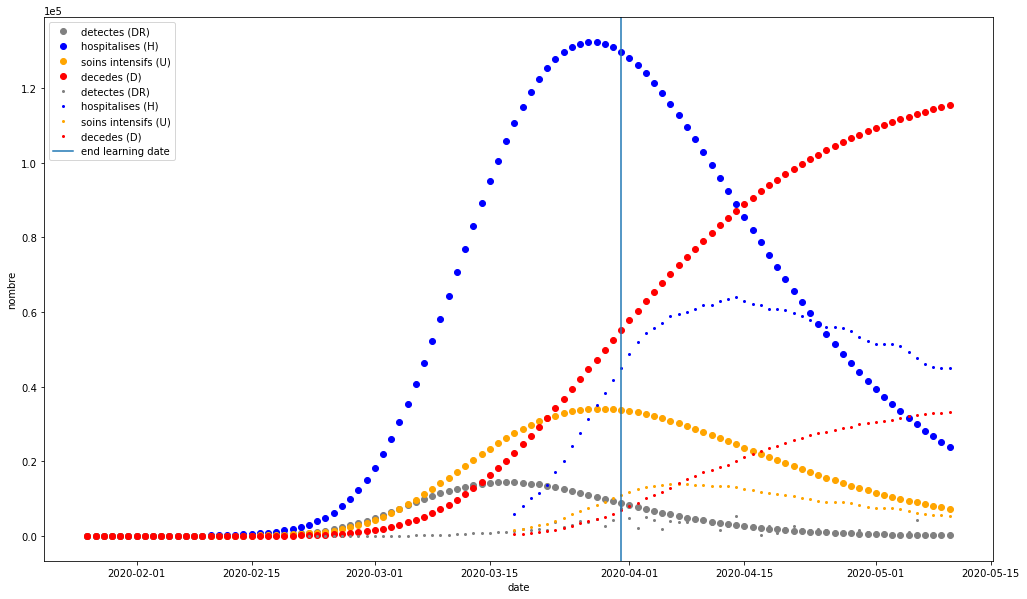

In [31]:
COLORS_PLOT=['grey','blue','orange','red']

model = SEIR(res_x[i // 31][i % 31])
model.reset(res_x[i // 31][i % 31])
end = -1
import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date((model.d0 + np.timedelta64(1, 'D') * sol.t)[:end], sol.y[indices[i], :end], label=labels[i],color=COLORS_PLOT[i])

plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.axvline(np.datetime64('2020-03-31'), label='end learning date')
plt.legend(loc="upper left")
plt.show()

Les données prédites après le 31 mars sont assez éloignées des données réelles, ce qui peut s'expliquer par l'effet latent du confinement mis en place le 18 mars.

### Question 8

Dans le cadre de l'approche plug-in, on définit $\sigma^*$ comme un argmax $\sigma \rightarrow p(data|x^*,\sigma)$

Puisque la fonction logarithme est strictement croissante sur $\mathbb{R}^{*}_+$, on étudie plutôt la fonction $\sigma \rightarrow log(p(data|x^*,\sigma)$


## Dérivée partielle selon $\sigma_C$

$log(p(data|x^*,\sigma))=-\displaystyle \frac{n_C}{2}log(\sigma_C^2) -\frac{1}{2}\sum_{i=1}{n_C}\frac{f_C(x^*,t_i)^2}{\sigma_c^2} + cte$ où $cte$ est indépendant de $\sigma_C$

$\displaystyle \frac{\partial log(p(data|x^*,\sigma)) }{\partial \sigma_C^2}=-\displaystyle \frac{n_C}{2}\frac{1}{\sigma_C^2} + \frac{1}{2}\sum_{i=1}^{n_C}\frac{f_C(x^*,t_i)^2}{\sigma_c^4} $

Par étude de cette dérivée, on en déduit que $\sigma_C \rightarrow p(data|x^*,\sigma)$ atteint un unique maximum en $\sigma_C^{*2}=\displaystyle \frac{1}{n_C}\sum_{i=1}^{n_C}f_C(x^*,t_i)^2$

## Maximal global

$\sigma \rightarrow p(data|x^*,\sigma)$ atteint un unique maximum défini par :
 - $\sigma_{DR}^{*2}=\displaystyle \frac{1}{n_{DR}}\sum_{i=1}^{n_{DR}}f_{DR}(x^*,t_i)^2$
 - $\sigma_C^{*2}=\displaystyle \frac{1}{n_C}\sum_{i=1}^{n_C}f_C(x^*,t_i)^2$ pour $C \in \{H,U,D,R\}$

### Question 9

Plug-in : $p(x|data) \sim p(data|x,\sigma^*)$ $\rightarrow$ 15 paramètres à optimiser 

Full-bayesien : $p(x,\sigma|data) \sim p(data|x,\sigma) \sigma_{DR}^{-1}\sigma_{H}^{-1}\sigma_{U}^{-1}\sigma_{D}^{-1}\sigma_{R}^{-1}$ $\rightarrow$ 20 paramètres à optimiser

### Question 10

Paramètres par défaut : 
- $N=5000$
- burn-in à 40%
- thinning à 1 sur 5

On contrôle le support des lois d'explorations avec la taille de l'intervalle des paramètres.
- plug-in & full bayesian : loi gaussienne de covariance, la matrice diagonale de la taille des intervalles avec facteur multiplicatif sigma_2_gaussian
- plug-in & full bayesian : loi uniforme multidimensionnelle dont le support est contrôlé par alpha_uniform

In [32]:
np.random.seed(0)
DIAG_INTERVAL=np.array([0.5, 0.15, 0.03, 0.1, 0.1,0.2,4.,10.,10.,0.5,0.07,19.,30.,99.,1e-3 - 1e-4])
#width of intervals for parameters -> use for scaling the exploration law

BOUNDS=[(0.4,0.9),
       (0.05,0.2),
       (0.01,0.04),
       (0.1,0.2),
       (0.1,0.2),
       (0.2,0.4),
       (8.,12.),
       (15.,25.),
       (10.,20.),
       (2.9,3.4),
       (0.01,0.08),
       (30,49),
       (0.,30),
       (1.,100.),
       (1e-4, 1e-3)]

def x_is_between_bounds(x, bounds=BOUNDS):
    boolean=True
    for i in range(x.size):
        boolean=boolean & (x[i]>=bounds[i][0]) & (x[i]<=bounds[i][1])
    return boolean

#### Dans le cas plug-in

In [33]:
def get_sigma_star(x_star, date_end):
    x11=int(x_star[11])
    x12=int(x_star[12])
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    all_err,all_size=meta_error(x_star, date_end, x11, x12, T_end)
    for i in range(all_err.size):
        all_err[i]=all_err[i]/all_size[i]
    return all_err

# likelihood p(x|data,sigma_star) [without constant]

def p_x_plug_in(x, sigma_star, date_end, bounds=BOUNDS):
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    if x_is_between_bounds(x,bounds):
        x11=int(x[11])
        x12=int(x[12])
        all_err,all_size=meta_error(x, date_end, x11, x12,T_end)
        all_err=all_err/sigma_star
        return np.exp(-0.5*np.sum(all_err))
    else:
        return 0
    
#exploration law : gaussian
def law_gaussian_pi(y,sigma_2, diag=DIAG_INTERVAL):
    return y+ np.sqrt(sigma_2*diag)*np.random.randn(y.size)

#exploration law : uniform
def law_uniform_pi(y,alpha, diag=DIAG_INTERVAL):
    return np.random.uniform(low=y-alpha*diag, high=y+alpha*diag)

def metropolis_hastings_plug_in(date_end,N,x0,sigma_star, method,diag=DIAG_INTERVAL,sigma_2_gaussian=1e-4, alpha_uniform=0.07,burn_in=0.4, thinning=0.2):
    """Return : the chain of x for the distribution, the acceptance array
    param:
    N : nb of iterations
    x0 : starting point
    sigma_star : array(5) :  sigma defined by plug-in
    method : either 'gaussian' or 'uniform'
    diag : array(x0.size) : defines the scaling hyperparameter
    
    sigma_2_gaussian : float : used for scaling gaussian exploration law
    alpha_uniform : float : used for scaling uniform exploration law
    
    burning : float(0,1) : part of starting data not used finally
    thinning : float(0,1) : part of global data finally used 
    """
    x_chain=np.zeros((N,x0.size))
    acceptance=np.zeros(N-1)
    x_chain[0]=x0
    for n in range(N-1):
        if method=="gaussian":
            y_new=law_gaussian_pi(x_chain[n],sigma_2_gaussian,diag)
        elif method=="uniform":
            y_new=law_uniform_pi(x_chain[n],alpha_uniform,diag)
        y_new[11]=int(y_new[11])
        y_new[12]=int(y_new[12])
        u_sim=np.random.uniform()
        if u_sim <= p_x_plug_in(y_new,sigma_star, date_end)/p_x_plug_in(x_chain[n],sigma_star, date_end):#loi symétrique
            x_chain[n+1]=y_new
            acceptance[n]=1
        else:
            x_chain[n+1]=x_chain[n]
    #burn_in
    
    x_chain=x_chain[int(burn_in*N):,:]
    
    #thinning
    
    x_chain=x_chain[::int(1/thinning),:] #we keep thinning*N (100*thinning percent)
    
    return x_chain, acceptance


In [34]:
x_star=res_x[i // 31][i % 31]
x_star[11]=int(x_star[11])
x_star[12]=int(x_star[12])
DATE_END= np.datetime64('2020-03-31')
sigma_star=get_sigma_star(x_star, DATE_END)
print(sigma_star)


[1437.79428649 6980.71652957 1682.90767276  961.4758159  2699.36336965]


##### Exploration gaussienne

In [35]:
%%time
x_chain_gaussian_pi, acceptance_gaussian_pi=metropolis_hastings_plug_in(DATE_END,N=5000,x0=x_star,sigma_star=sigma_star,method="gaussian",sigma_2_gaussian=1e-5)
#np.save("result/Q10/x_chain_plug_in_gaussian", x_chain_gaussian_pi)
#np.save("result/Q10/acceptance_plug_in_gaussian", acceptance_gaussian_pi)

Wall time: 1min 1s


In [36]:
nb_points, size_param=x_chain_gaussian_pi.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [37]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_gaussian_pi),decimals=4))

Moyenne de l'acceptance: 0.2739


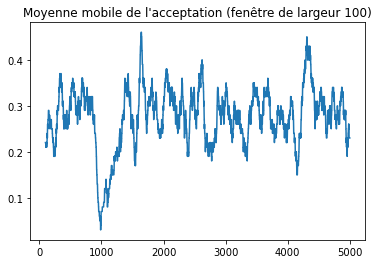

In [38]:
plt.plot(pd.DataFrame(acceptance_gaussian_pi).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

Le taux d'acceptation est raisonnable dans ce cas.

##### Exploration uniforme

In [39]:
%%time
x_chain_uniform_pi, acceptance_uniform_pi=metropolis_hastings_plug_in(DATE_END,N=5000,x0=x_star,sigma_star=sigma_star,method="uniform", alpha_uniform=0.01)
#np.save("result/Q10/x_chain_plug_in_uniform", x_chain_uniform_pi)
#np.save("result/Q10/acceptance_plug_in_uniform", acceptance_uniform_pi)

Wall time: 1min


In [40]:
nb_points, size_param=x_chain_uniform_pi.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [41]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_uniform_pi),decimals=4))

Moyenne de l'acceptance: 0.3679


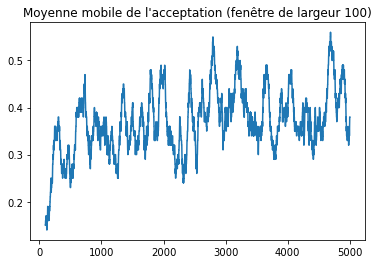

In [42]:
plt.plot(pd.DataFrame(acceptance_uniform_pi).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

Le taux d'acceptation est raisonnable dans ce cas.

#### Dans le cas full-bayésien

In [43]:
SIGMA_INTERVAL=2*sigma_star

# likelihood p(x,sigma_2|data) [without constant]

def p_x_full_bayesian(x, sigma_2, date_end, bounds=BOUNDS): #bound on sigma_2 : positive
    T_end = (date_end - np.datetime64('2020-01-25')) / np.timedelta64(1, 'D')
    if x_is_between_bounds(x,bounds) and np.all(sigma_2>np.zeros(sigma_2.size)):
        x11=int(x[11])
        x12=int(x[12])
        all_err,all_size=meta_error(x, date_end, x11, x12,T_end)
        all_err=all_err/sigma_2
        prod_sigma=np.prod(sigma_2**(-0.5*all_size))
        return prod_sigma*np.exp(-0.5*np.sum(all_err))
    else:
        return 0
    
#exploration law : gaussian
def law_gaussian_fb(y,sigma_2, diag=DIAG_INTERVAL, sigma_diag=SIGMA_INTERVAL):
    """ Size of y : x.size + sigma_2.size
    sigma_2_diag : scaling parameter"""
    diag_final=np.concatenate((diag,sigma_diag))
    return y+ np.sqrt(sigma_2*diag_final)*np.random.randn(y.size)

#exploration law : uniform
def law_uniform_fb(y,alpha, diag=DIAG_INTERVAL,sigma_diag=SIGMA_INTERVAL):
    diag_final=np.concatenate((diag,sigma_diag))
    return np.random.uniform(low=y-alpha*diag_final, high=y+alpha*diag_final)

def metropolis_hastings_full_bayesian(date_end,N,x0,sigma_2_0, method,diag=DIAG_INTERVAL, sigma_diag=SIGMA_INTERVAL,sigma_2_gaussian=3e-4, alpha_uniform=0.003,burn_in=0.4, thinning=0.2):
    """Return : the chain of x for the distribution,the chain of sigma_2 for the ditribution, the acceptance array
    param:
    N : nb of iterations
    x0 : starting point
    sigma_2_0 : array(5) :  starting point for sigma
    method : either 'gaussian' or 'uniform'
    diag : array(x0.size) : defines the scaling hyperparameter
    
    sigma_2_gaussian : float : used for scaling gaussian exploration law
    alpha_uniform : float : used for scaling uniform exploration law
    
    burning : float(0,1) : part of starting data not used finally
    thinning : float(0,1) : part of global data finally used 
    """
    x_sigma_chain=np.zeros((N,x0.size + sigma_2_0.size))
    acceptance=np.zeros(N-1)
    x_sigma_chain[0]=np.concatenate((x0,sigma_2_0))
    
    for n in range(N-1):
        if method=="gaussian":
            y_new=law_gaussian_fb(x_sigma_chain[n],sigma_2_gaussian, diag,sigma_diag)
        elif method=="uniform":
            y_new=law_uniform_fb(x_sigma_chain[n],alpha_uniform,diag, sigma_diag)
        y_new[11]=int(y_new[11])
        y_new[12]=int(y_new[12])
        u_sim=np.random.uniform()
        if u_sim <= p_x_full_bayesian(y_new[:x0.size], y_new[x0.size:], date_end)/p_x_full_bayesian(x_sigma_chain[n,:x0.size],x_sigma_chain[n,x0.size:], date_end):#loi symétrique
            x_sigma_chain[n+1]=y_new
            acceptance[n]=1
        else:
            x_sigma_chain[n+1]=x_sigma_chain[n]
    #burn_in
    
    x_sigma_chain=x_sigma_chain[int(burn_in*N):,:]
    
    #thinning
    
    x_sigma_chain=x_sigma_chain[::int(1/thinning),:] #we keep thinning*N (100*thinning percent)
    
    return x_sigma_chain[:,:x0.size],x_sigma_chain[:,x0.size:], acceptance


##### Exploration gaussienne

In [44]:
%%time
x_chain_gaussian_fb, sigma_chain_gaussian_fb,acceptance_gaussian_fb =metropolis_hastings_full_bayesian(DATE_END,N=5000,x0=x_star,sigma_2_0=sigma_star,method="gaussian",sigma_2_gaussian=1e-5)
#np.save("result/Q10/x_chain_fb_gaussian", x_chain_gaussian_fb)
#np.save("result/Q10/acceptance_fb_gaussian", acceptance_gaussian_fb)
#np.save("result/Q10/sigma_chain_fb_gaussian", sigma_chain_gaussian_fb)

Wall time: 58.4 s


In [45]:
nb_points, size_param=x_chain_gaussian_fb.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [46]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_gaussian_fb),decimals=4))

Moyenne de l'acceptance: 0.3065


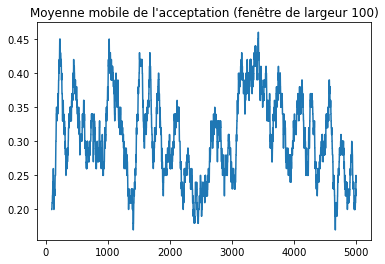

In [47]:
plt.plot(pd.DataFrame(acceptance_gaussian_fb).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

Le taux d'acceptation est raisonnable dans ce cas.

##### Exploration uniforme

In [48]:
%%time
x_chain_uniform_fb, sigma_chain_uniform_fb,acceptance_uniform_fb=metropolis_hastings_full_bayesian(DATE_END,N=5000,x0=x_star,sigma_2_0=sigma_star,method="uniform", alpha_uniform=0.006)
#np.save("result/Q10/x_chain_fb_uniform", x_chain_uniform_fb)
#np.save("result/Q10/acceptance_fb_uniform", acceptance_uniform_fb)
#np.save("result/Q10/sigma_chain_fb_uniform", sigma_chain_uniform_fb)

Wall time: 1min 3s


In [49]:
nb_points, size_param=x_chain_uniform_fb.shape
print("Distribution de taille :", nb_points)

Distribution de taille : 600


In [50]:
print("Moyenne de l'acceptance:",np.round(np.mean(acceptance_uniform_fb),decimals=4))

Moyenne de l'acceptance: 0.3899


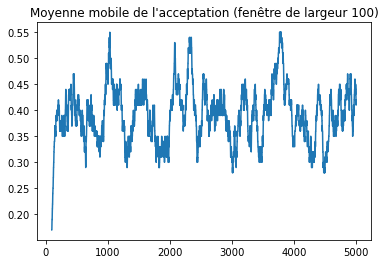

In [51]:
plt.plot(pd.DataFrame(acceptance_uniform_fb).rolling(100).mean().values)
plt.title("Moyenne mobile de l'acceptation (fenêtre de largeur 100)")
plt.show()

Taux d'acceptation raisonnable.

##### Posterior vs Prior (PI gaussien - PI uniforme - FB gaussien-FB uniforme) : échantillons de taille 600

Comparaison des distributions prior et posterior pour les différentes méthodes d'échantillonnage.

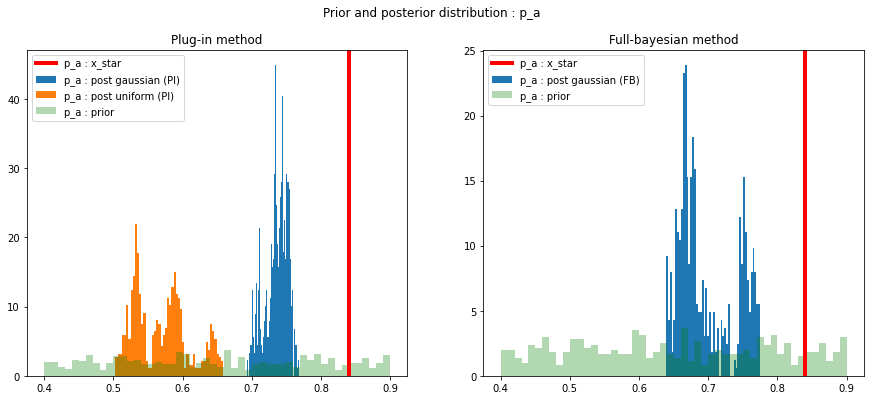

Moyenne PRIOR :  0.6496 - Variance PRIOR :  0.02053

PI : Moyenne POST (gaussian) :  0.7357 - PI : Variance POST (gaussian):  0.00027
PI : Moyenne POST (uniform) :  0.5689 - PI : Variance POST (uniform):  0.00159

FB : Moyenne POST (gaussian) :  0.6978 - FB : Variance POST (gaussian):  0.00169
FB : Moyenne POST (uniform) :  0.678 - FB : Variance POST (uniform):  0.00036
-----------------------------------------------------------------------------------------------


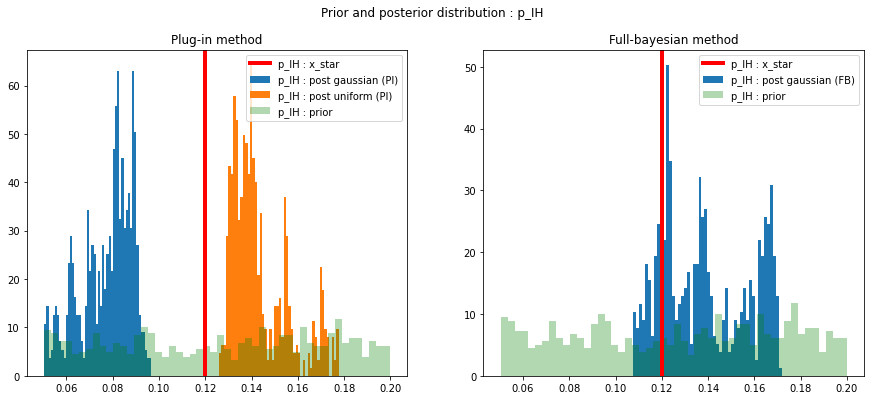

Moyenne PRIOR :  0.1262 - Variance PRIOR :  0.00195

PI : Moyenne POST (gaussian) :  0.0772 - PI : Variance POST (gaussian):  0.00012
PI : Moyenne POST (uniform) :  0.1437 - PI : Variance POST (uniform):  0.00016

FB : Moyenne POST (gaussian) :  0.1386 - FB : Variance POST (gaussian):  0.00035
FB : Moyenne POST (uniform) :  0.1278 - FB : Variance POST (uniform):  2e-05
-----------------------------------------------------------------------------------------------


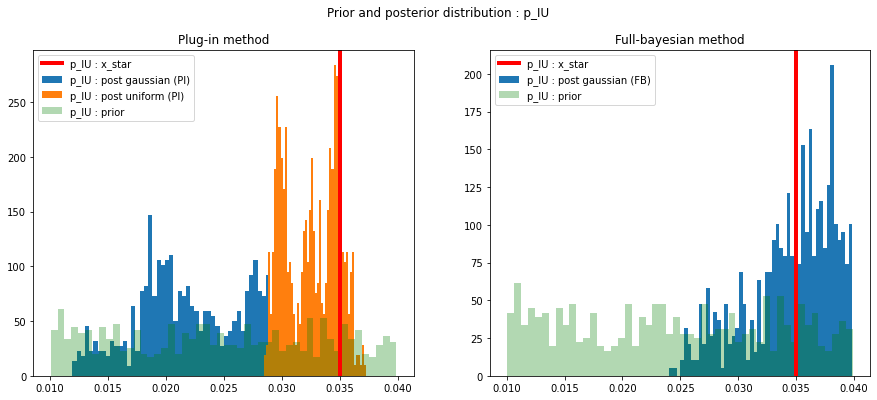

Moyenne PRIOR :  0.0244 - Variance PRIOR :  8e-05

PI : Moyenne POST (gaussian) :  0.0219 - PI : Variance POST (gaussian):  2e-05
PI : Moyenne POST (uniform) :  0.0326 - PI : Variance POST (uniform):  1e-05

FB : Moyenne POST (gaussian) :  0.0346 - FB : Variance POST (gaussian):  1e-05
FB : Moyenne POST (uniform) :  0.0344 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


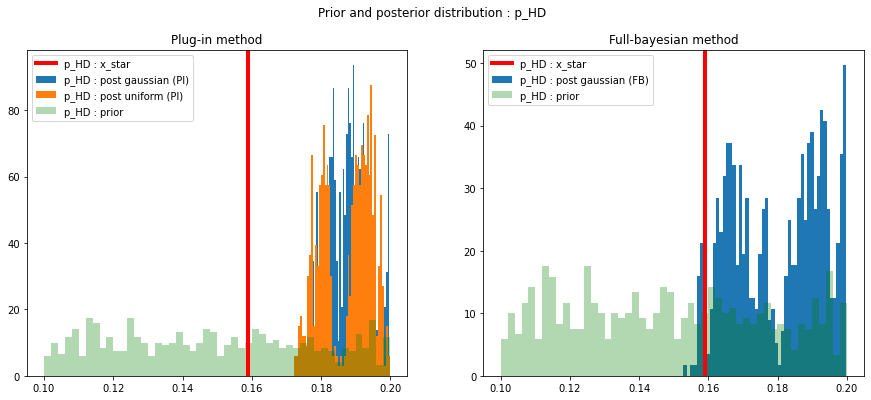

Moyenne PRIOR :  0.1487 - Variance PRIOR :  0.00081

PI : Moyenne POST (gaussian) :  0.188 - PI : Variance POST (gaussian):  3e-05
PI : Moyenne POST (uniform) :  0.1874 - PI : Variance POST (uniform):  5e-05

FB : Moyenne POST (gaussian) :  0.1799 - FB : Variance POST (gaussian):  0.00017
FB : Moyenne POST (uniform) :  0.1671 - FB : Variance POST (uniform):  3e-05
-----------------------------------------------------------------------------------------------


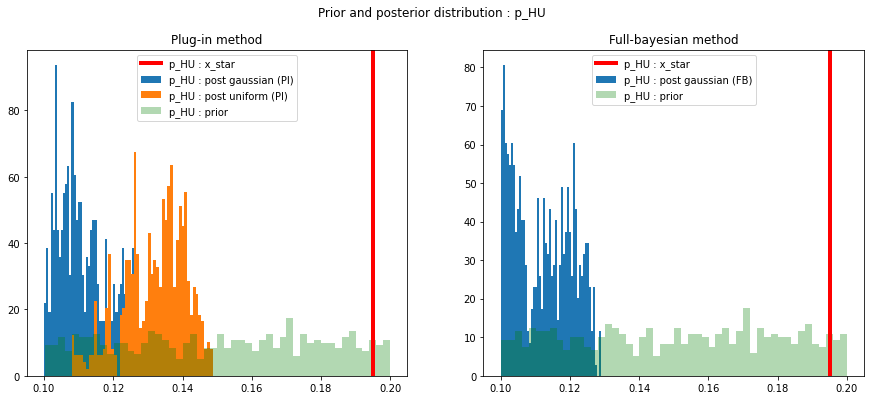

Moyenne PRIOR :  0.1506 - Variance PRIOR :  0.00084

PI : Moyenne POST (gaussian) :  0.112 - PI : Variance POST (gaussian):  6e-05
PI : Moyenne POST (uniform) :  0.1319 - PI : Variance POST (uniform):  8e-05

FB : Moyenne POST (gaussian) :  0.1121 - FB : Variance POST (gaussian):  7e-05
FB : Moyenne POST (uniform) :  0.1121 - FB : Variance POST (uniform):  2e-05
-----------------------------------------------------------------------------------------------


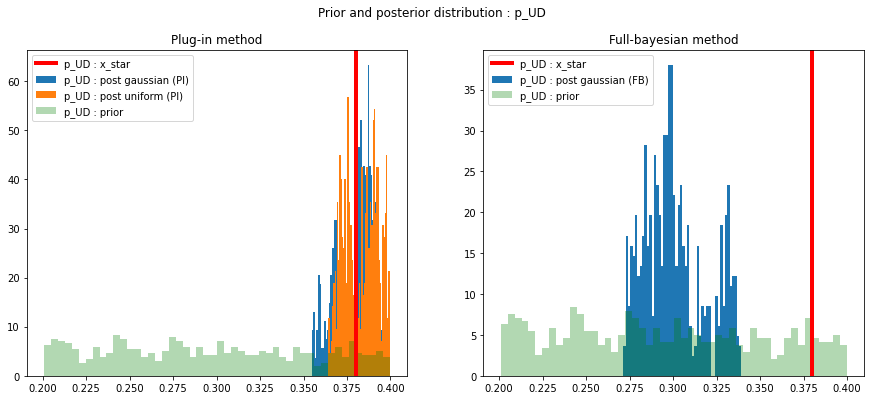

Moyenne PRIOR :  0.2948 - Variance PRIOR :  0.00331

PI : Moyenne POST (gaussian) :  0.3801 - PI : Variance POST (gaussian):  0.00012
PI : Moyenne POST (uniform) :  0.3829 - PI : Variance POST (uniform):  9e-05

FB : Moyenne POST (gaussian) :  0.3012 - FB : Variance POST (gaussian):  0.00032
FB : Moyenne POST (uniform) :  0.3736 - FB : Variance POST (uniform):  2e-05
-----------------------------------------------------------------------------------------------


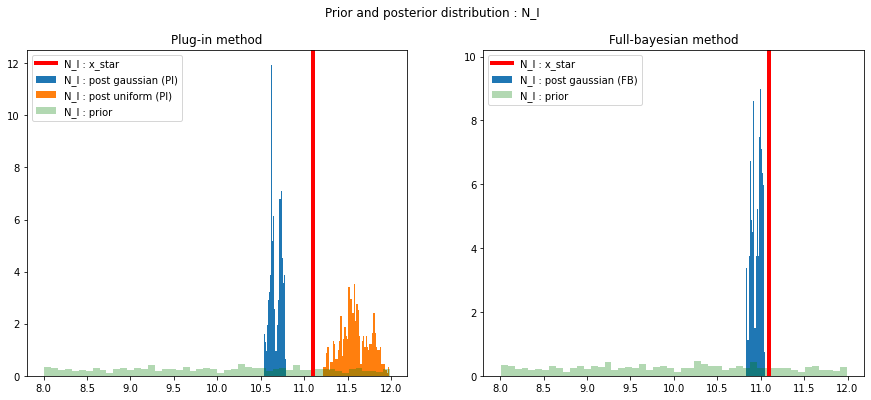

Moyenne PRIOR :  9.975 - Variance PRIOR :  1.24206

PI : Moyenne POST (gaussian) :  10.673 - PI : Variance POST (gaussian):  0.00423
PI : Moyenne POST (uniform) :  11.5925 - PI : Variance POST (uniform):  0.02835

FB : Moyenne POST (gaussian) :  10.9463 - FB : Variance POST (gaussian):  0.00312
FB : Moyenne POST (uniform) :  11.1855 - FB : Variance POST (uniform):  0.01228
-----------------------------------------------------------------------------------------------


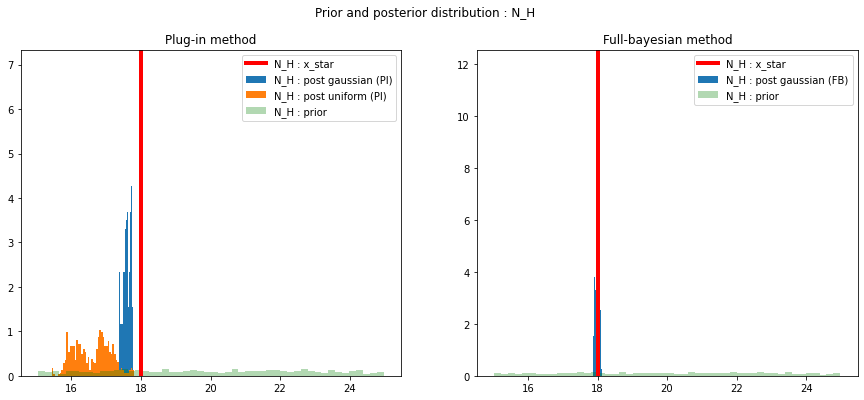

Moyenne PRIOR :  19.9482 - Variance PRIOR :  7.75239

PI : Moyenne POST (gaussian) :  17.5788 - PI : Variance POST (gaussian):  0.01164
PI : Moyenne POST (uniform) :  16.6018 - PI : Variance POST (uniform):  0.26787

FB : Moyenne POST (gaussian) :  17.9814 - FB : Variance POST (gaussian):  0.00283
FB : Moyenne POST (uniform) :  17.6085 - FB : Variance POST (uniform):  0.23854
-----------------------------------------------------------------------------------------------


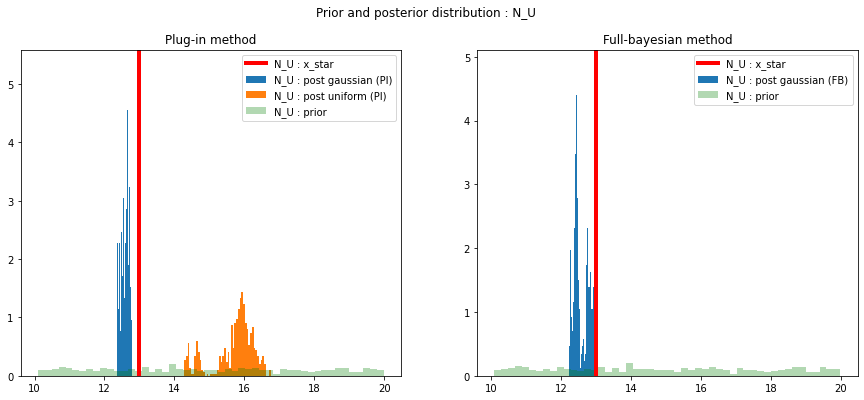

Moyenne PRIOR :  14.9313 - Variance PRIOR :  8.30161

PI : Moyenne POST (gaussian) :  12.5826 - PI : Variance POST (gaussian):  0.01303
PI : Moyenne POST (uniform) :  15.7112 - PI : Variance POST (uniform):  0.34099

FB : Moyenne POST (gaussian) :  12.5678 - FB : Variance POST (gaussian):  0.04087
FB : Moyenne POST (uniform) :  13.4545 - FB : Variance POST (uniform):  0.0543
-----------------------------------------------------------------------------------------------


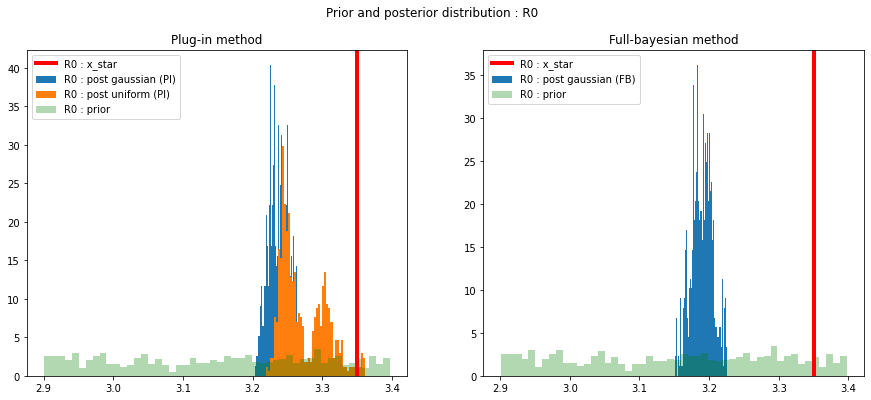

Moyenne PRIOR :  3.1492 - Variance PRIOR :  0.02138

PI : Moyenne POST (gaussian) :  3.2364 - PI : Variance POST (gaussian):  0.0002
PI : Moyenne POST (uniform) :  3.2727 - PI : Variance POST (uniform):  0.00106

FB : Moyenne POST (gaussian) :  3.1894 - FB : Variance POST (gaussian):  0.00024
FB : Moyenne POST (uniform) :  3.175 - FB : Variance POST (uniform):  0.00137
-----------------------------------------------------------------------------------------------


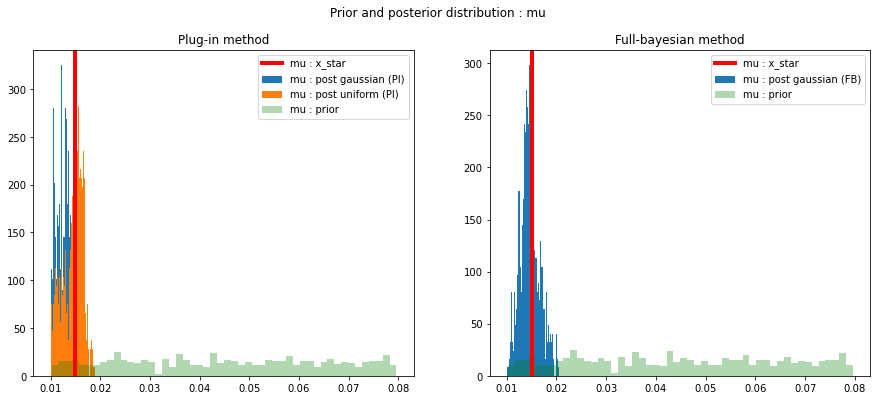

Moyenne PRIOR :  0.0449 - Variance PRIOR :  0.0004

PI : Moyenne POST (gaussian) :  0.013 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0144 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0147 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0127 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


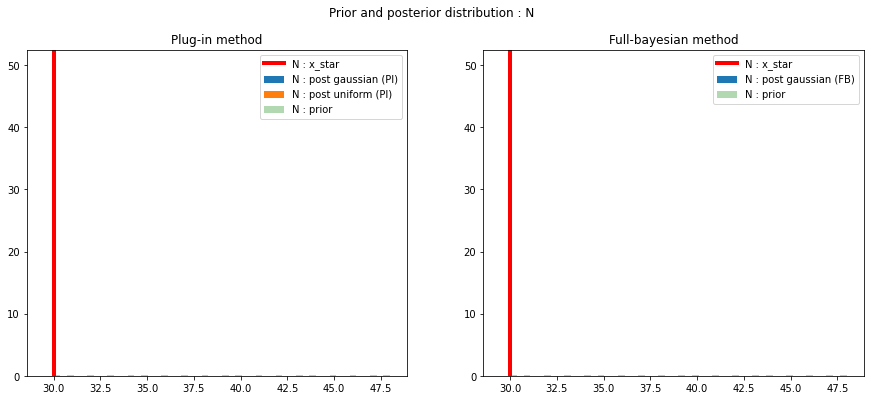

Moyenne PRIOR :  38.7717 - Variance PRIOR :  29.94953

PI : Moyenne POST (gaussian) :  30.0 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  30.0 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  30.0 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  30.0 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


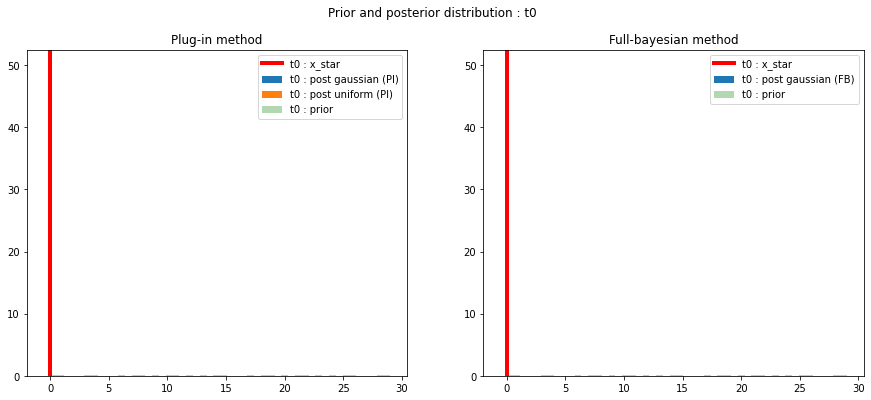

Moyenne PRIOR :  14.6917 - Variance PRIOR :  73.57326

PI : Moyenne POST (gaussian) :  0.0 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------


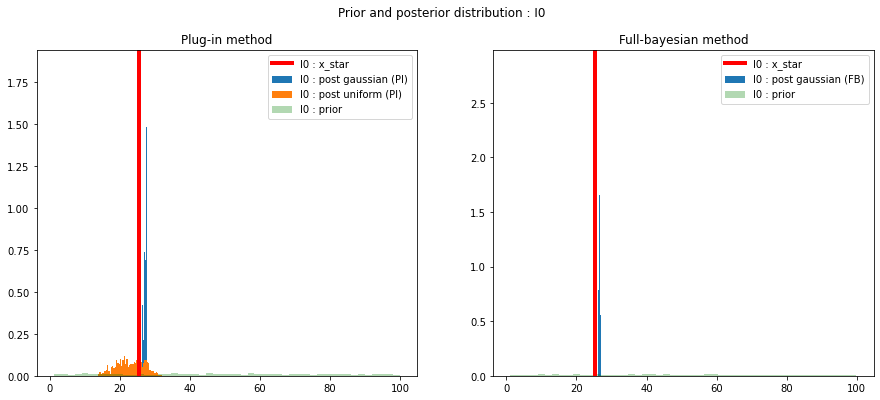

Moyenne PRIOR :  48.3657 - Variance PRIOR :  778.33323

PI : Moyenne POST (gaussian) :  27.2624 - PI : Variance POST (gaussian):  0.17279
PI : Moyenne POST (uniform) :  22.8975 - PI : Variance POST (uniform):  15.84369

FB : Moyenne POST (gaussian) :  26.5001 - FB : Variance POST (gaussian):  0.04129
FB : Moyenne POST (uniform) :  28.3118 - FB : Variance POST (uniform):  5.50144
-----------------------------------------------------------------------------------------------


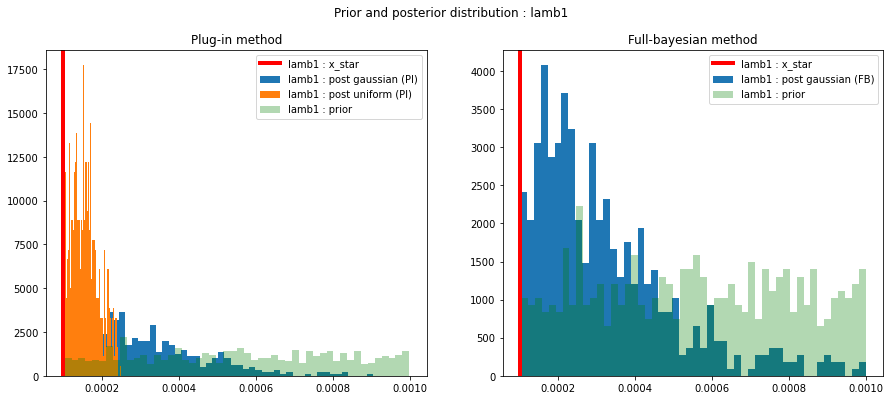

Moyenne PRIOR :  0.0006 - Variance PRIOR :  0.0

PI : Moyenne POST (gaussian) :  0.0003 - PI : Variance POST (gaussian):  0.0
PI : Moyenne POST (uniform) :  0.0002 - PI : Variance POST (uniform):  0.0

FB : Moyenne POST (gaussian) :  0.0003 - FB : Variance POST (gaussian):  0.0
FB : Moyenne POST (uniform) :  0.0002 - FB : Variance POST (uniform):  0.0
-----------------------------------------------------------------------------------------------
Wall time: 9.67 s


In [65]:
%%time
LABELS=["p_a","p_IH","p_IU","p_HD","p_HU","p_UD","N_I","N_H","N_U","R0","mu","N","t0","I0","lamb1"]

for i in range(x_chain_gaussian_pi[0].size):
    bounds_i=BOUNDS[i]
    if i!=11 and i!=12:
        uniform_reference=np.random.uniform(low=bounds_i[0], high=bounds_i[1],size=np.size(x_chain_gaussian_pi[:,0]))
        
    else:
        uniform_reference=np.random.randint(low=int(bounds_i[0]), high=int(bounds_i[1]),size=np.size(x_chain_gaussian_pi[:,0]))
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
    fig.suptitle("Prior and posterior distribution : "+LABELS[i])
    ax1.hist(x_chain_gaussian_pi[:,i], density=True, bins=50, label=LABELS[i]+" : post gaussian (PI)")
    ax1.hist(x_chain_uniform_pi[:,i], density=True, bins=50, label=LABELS[i]+" : post uniform (PI)")
    ax1.hist(uniform_reference, density=True, bins=50, alpha=0.3,label=LABELS[i]+" : prior",color="green")
    ax1.axvline(x=x_star[i],linewidth=4, color='r', label=LABELS[i]+ " : x_star")
    ax1.set_title("Plug-in method")
    ax1.legend()
    ax2.hist(x_chain_gaussian_fb[:,i], density=True, bins=50, label=LABELS[i]+" : post gaussian (FB)")
    #ax2.hist(x_chain_uniform_fb[:,i], density=True, bins=50, label=LABELS[i]+" : post uniform (FB)")
    ax2.hist(uniform_reference, density=True, bins=50, alpha=0.3,label=LABELS[i]+" : prior", color="green")
    ax2.axvline(x=x_star[i],linewidth=4, color='r', label=LABELS[i]+ " : x_star")
    ax2.set_title("Full-bayesian method")
    ax2.legend()
    plt.show()
    print("Moyenne PRIOR : ",np.round(np.mean(uniform_reference),decimals=4), "- Variance PRIOR : ",np.round(np.var(uniform_reference),decimals=5))
    print("")
    print("PI : Moyenne POST (gaussian) : ",np.round(np.mean(x_chain_gaussian_pi[:,i]),decimals=4),"- PI : Variance POST (gaussian): ",np.round(np.var(x_chain_gaussian_pi[:,i]),decimals=5))
    print("PI : Moyenne POST (uniform) : ",np.round(np.mean(x_chain_uniform_pi[:,i]),decimals=4),"- PI : Variance POST (uniform): ",np.round(np.var(x_chain_uniform_pi[:,i]),decimals=5))
    print("")
    print("FB : Moyenne POST (gaussian) : ",np.round(np.mean(x_chain_gaussian_fb[:,i]),decimals=4),"- FB : Variance POST (gaussian): ",np.round(np.var(x_chain_gaussian_fb[:,i]),decimals=5))
    print("FB : Moyenne POST (uniform) : ",np.round(np.mean(x_chain_uniform_fb[:,i]),decimals=4),"- FB : Variance POST (uniform): ",np.round(np.var(x_chain_uniform_fb[:,i]),decimals=5))
    print("-----------------------------------------------------------------------------------------------")

A titre d'indication sont données les distributions a posteriori des paramètres sigma pour la méthode "full bayesian" de type gaussien (la méthode uniforme ne permet pas d'avoir une distribution précise sur $\sigma$)

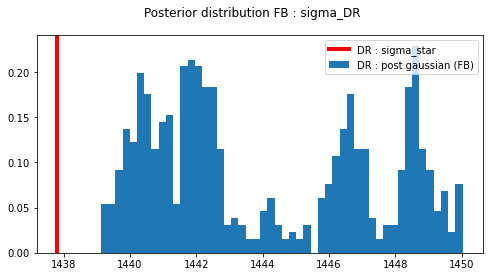

Sigma_star :  1437.7942864944216
FB : Moyenne POST (gaussian) :  1444.0276 - FB : Variance POST (gaussian):  10.82958


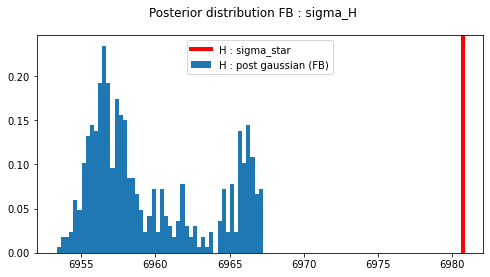

Sigma_star :  6980.716529571081
FB : Moyenne POST (gaussian) :  6959.6165 - FB : Variance POST (gaussian):  16.22845


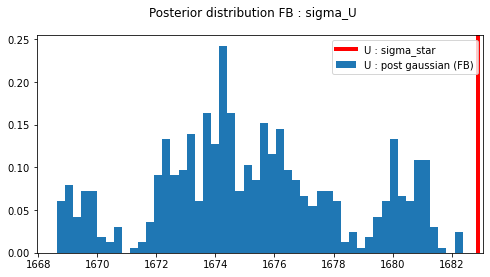

Sigma_star :  1682.9076727595182
FB : Moyenne POST (gaussian) :  1675.2881 - FB : Variance POST (gaussian):  11.02102


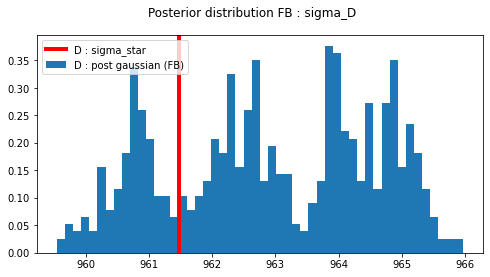

Sigma_star :  961.4758158960801
FB : Moyenne POST (gaussian) :  962.9365 - FB : Variance POST (gaussian):  2.58705


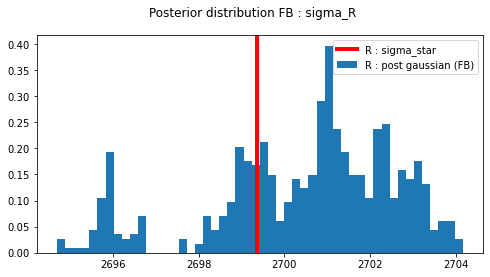

Sigma_star :  2699.3633696476904
FB : Moyenne POST (gaussian) :  2700.4958 - FB : Variance POST (gaussian):  4.48379
Wall time: 1.08 s


In [63]:
%%time
LABELS_SIGMA=["DR","H","U","D","R"]
for i in range(sigma_chain_gaussian_fb[0].size):
    fig, (ax1) = plt.subplots(figsize=(8,4))
    fig.suptitle("Posterior distribution FB : sigma_"+LABELS_SIGMA[i])
    ax1.hist(sigma_chain_gaussian_fb[:,i], density=True, bins=50, label=LABELS_SIGMA[i]+" : post gaussian (FB)")
    ax1.axvline(x=sigma_star[i],linewidth=4, color='r', label=LABELS_SIGMA[i]+ " : sigma_star")
    #ax1.hist(sigma_chain_uniform_fb[:,i], density=True, bins=50, label=LABELS_SIGMA[i]+" : post uniform (FB)")
    ax1.legend()
    plt.show()
    print("Sigma_star : ", sigma_star[i])
    print("FB : Moyenne POST (gaussian) : ",np.round(np.mean(sigma_chain_gaussian_fb[:,i]),decimals=4),"- FB : Variance POST (gaussian): ",np.round(np.var(sigma_chain_gaussian_fb[:,i]),decimals=5))
    #print("FB : Moyenne POST (uniform) : ",np.round(np.mean(sigma_chain_uniform_fb[:,i]),decimals=4),"- FB : Variance POST (uniform): ",np.round(np.var(sigma_chain_uniform_fb[:,i]),decimals=5))

##### Matrice des corrélations

In [54]:
def color_red_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if abs(val) <0.20 else'green' if abs(val) >0.60 else 'black'
    return 'color: %s' % color

In [55]:
print("Matrice des corrélations PI gaussien:")
corr_gaussian_pi=np.corrcoef(x_chain_gaussian_pi.T)
corr_df_gaussian_pi=pd.DataFrame(corr_gaussian_pi, index=LABELS,columns=LABELS).round(2)
corr_df_gaussian_pi.style.applymap(color_red_green)


Matrice des corrélations PI gaussien:


C:\Users\maxen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\maxen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Globalement nous n'avons pas de paramètres qui sont très corrélés entre eux (>0.8), mais nous en constatons certains qui sont moyennement corrélés :

$\{ p_{HU}, p_{IH} \}, \{ I_0^-, N_I \}$

In [56]:
print("Matrice des corrélations PI uniform:")
corr_uniform_pi=np.corrcoef(x_chain_uniform_pi.T)
corr_df_uniform_pi=pd.DataFrame(corr_uniform_pi, index=LABELS,columns=LABELS).round(2)
corr_df_uniform_pi.style.applymap(color_red_green)

Matrice des corrélations PI uniform:


C:\Users\maxen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\maxen\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Globalement nous avons pas de paramètres qui sont très corrélés entre eux (>0.8), mais nous en constatons certains qui sont moyennement corrélés :

$\{p_a, I_0^-\},\{ p_{IU}, p_{HD}\} \{ p_{IU}, N_U\}, \{ N_I, I_0^-\}$

In [57]:
print("Matrice des corrélations FB gaussien:")
corr_gaussian_fb=np.corrcoef(x_chain_gaussian_fb.T)
corr_df_gaussian_fb=pd.DataFrame(corr_gaussian_fb, index=LABELS,columns=LABELS).round(2)
corr_df_gaussian_fb.style.applymap(color_red_green)

Matrice des corrélations FB gaussien:


Nous avons les couple $\{ p_a, N_H\}, \{ p_{IH}, p_{HD}\}, \{R_0,p_{IH}\}, \{N_I, p_{HD}\}$ qui sont très corrélés entre eux (>0.8) mais nous en constatons certains qui sont moyennement corrélés :

$\{N_I, p_{IH}\}, \{N_H,p_{HU}\}, \{R_0, N_I\}, \{\mu, N_I\}, \{R_0,N_U\}$

### Résultats sur l'incertitude des paramètres et la prédiction (plug-in gaussien)

Tous les paramètres on gagné en certitude.

Nous utilisons les paramètres obtenus avec la méthode plug-in post gaussien et les paramètres de $x^*$ si l'estimation ne change pas l'incertitude.

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 45258.66022532003
La date où on détecte le plus de patients : 2020-05-08


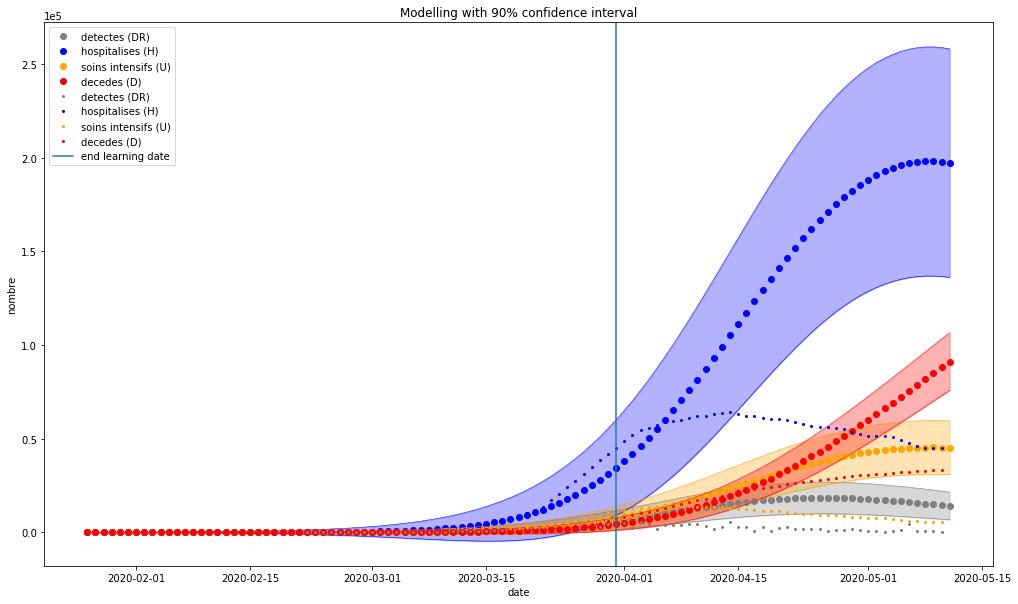

In [73]:
ALPHA=0.05
import scipy.stats as stats

quantile_alpha=stats.norm.ppf(1-ALPHA)

params = x_star
params[0]=0.74
params[1]=0.082
params[2]=0.018
params[3]=0.185
params[4] = 0.108
params[6] = 10.6
params[7] = 17.75
params[8]=12.5
params[9]=3.22
params[10] = 0.013
params[11] = 30
params[12] = 0
params[13]=27.2
params[14]=0.0002
model.reset(params)

COLORS_PLOT=['grey','blue','orange','red']

import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i],color=COLORS_PLOT[i])
    y_i_plus= sol.y[indices[i], :] +np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    y_i_minus= sol.y[indices[i], :] -np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_plus , color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_minus, color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.fill_between(model.d0 + np.timedelta64(1, 'D') * sol.t, y_i_plus, y_i_minus, color=COLORS_PLOT[i], alpha=0.3)
    
    
    
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.axvline(np.datetime64('2020-03-31'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title ("Modelling with 90% confidence interval")
plt.show()

### Résultats sur l'incertitude des paramètres et la prédiction (plug-in uniforme)

Tous les paramètres on gagné en certitude.

Nous utilisons les paramètres obtenus avec la méthode plug-in post uniforme et les paramètres de $x^*$ si l'estimation ne change pas l'incertitude.

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 78523.61295277895
La date où on détecte le plus de patients : 2020-05-10


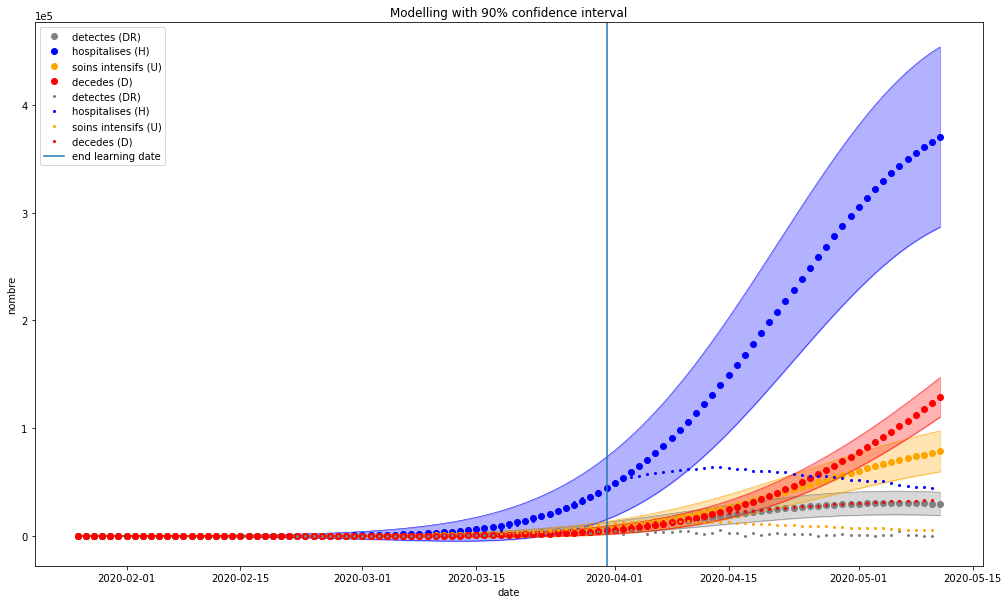

In [76]:
ALPHA=0.05
import scipy.stats as stats

quantile_alpha=stats.norm.ppf(1-ALPHA)

params = x_star
params[0]=0.53
params[1]=0.14
params[3]=0.187
params[4] = 0.137
params[6]=11.6
params[7] = 17
params[8]=16
params[9]=3.25
params[11] = 30
params[12] = 0
params[14]=0.0001
model.reset(params)

COLORS_PLOT=['grey','blue','orange','red']

import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i],color=COLORS_PLOT[i])
    y_i_plus= sol.y[indices[i], :] +np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    y_i_minus= sol.y[indices[i], :] -np.sqrt(sol.y[indices[i], :]*sigma_star[i])*quantile_alpha
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_plus , color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_minus, color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.fill_between(model.d0 + np.timedelta64(1, 'D') * sol.t, y_i_plus, y_i_minus, color=COLORS_PLOT[i], alpha=0.3)
    
    
    
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.axvline(np.datetime64('2020-03-31'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.title ("Modelling with 90% confidence interval")
plt.savefig("forecasting_first_learning_plug_in_uniform.png")
plt.show()

### Résultats sur l'incertitude des paramètres et la prédiction (full_bayesian gaussien)

On gagne en certitude sur tous les paramètres.

Nous utilisons les paramètres obtenus avec la méthode full_bayesian post gaussien et les paramètres de $x^*$ si l'estimation ne change pas l'incertitude.

La date du début de l'épidémie:  2020-01-25
La fin de simulation:  2020-05-11
Le nombre maximal de patients détectés : 80822.2160770165
La date où on détecte le plus de patients : 2020-05-10


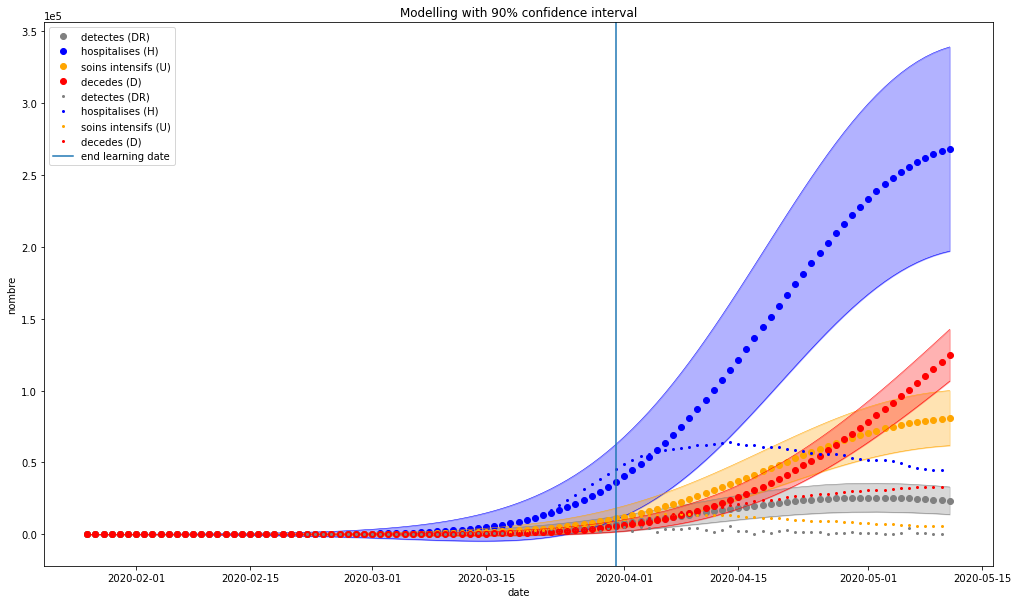

In [68]:
ALPHA=0.05
import scipy.stats as stats

quantile_alpha=stats.norm.ppf(1-ALPHA)

params = x_star
params[0] = 0.68
params[1] = 0.123
params[2]=0.038
params[3] = 0.185
params[4] = 0.102
params[5] = 0.3
params[6] = 11.
params[8]=12.4
params[9]=3.2
params[11] = 30
params[12] = 0
params[13] = 26.5

sigma_bayesian=np.zeros(5)
sigma_bayesian[0]=1442
sigma_bayesian[1]=6956
sigma_bayesian[2]=1674.5
sigma_bayesian[3]=964
sigma_bayesian[4]=2701

model.reset(params)

COLORS_PLOT=['grey','blue','orange','red']

import matplotlib.pyplot as plt
sol = model.evolution_T(True)
nb_maximum, date_maximum = model.soins_intensifs()
print("Le nombre maximal de patients détectés : {}".format(nb_maximum))
print("La date où on détecte le plus de patients : {}".format(model.d0 + np.timedelta64(int(date_maximum), 'D')))
plt.figure(figsize=(17, 10))
indices = [9, 5, 6, 8]
labels = ["detectes (DR)", "hospitalises (H)", "soins intensifs (U)", "decedes (D)"]
for i in range(4):
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t, sol.y[indices[i], :], label=labels[i],color=COLORS_PLOT[i])
    y_i_plus= sol.y[indices[i], :] +np.sqrt(sol.y[indices[i], :]*sigma_bayesian[i])*quantile_alpha
    y_i_minus= sol.y[indices[i], :] -np.sqrt(sol.y[indices[i], :]*sigma_bayesian[i])*quantile_alpha
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_plus , color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.plot_date(model.d0 + np.timedelta64(1, 'D') * sol.t,y_i_minus, color=COLORS_PLOT[i],linestyle='-',linewidth=0.5,markersize=0)
    plt.fill_between(model.d0 + np.timedelta64(1, 'D') * sol.t, y_i_plus, y_i_minus, color=COLORS_PLOT[i], alpha=0.3)
    
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.plot_date(data_nb_cumule.date, data_nb_cumule.nbre, label='detectes (DR)', markersize=2,color=COLORS_PLOT[0])
plt.plot_date(data_hospital.date, data_hospital.hosp, label='hospitalises (H)', markersize=2,color=COLORS_PLOT[1])
plt.plot_date(data_hospital.date, data_hospital.rea, label='soins intensifs (U)', markersize=2,color=COLORS_PLOT[2])
plt.plot_date(data_hospital.date, data_hospital.dc, label='decedes (D)', markersize=2,color=COLORS_PLOT[3])
plt.axvline(np.datetime64('2020-03-31'), label='end learning date')
plt.legend(loc="upper left")
plt.xlabel("date")
plt.ylabel("nombre")
plt.title ("Modelling with 90% confidence interval")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()

## CONCLUSION

La méthode plug-in uniforme est plus proche des données réelles en terme de vitesse de l'épidémie, mais sur-estime les ordres de grandeur poste date de fin d'entraînement notamment concernant le nombre de personnes hospitalisées, ce qui est du à la non prise en compte du confinement, absente de la période d'apprentissage.

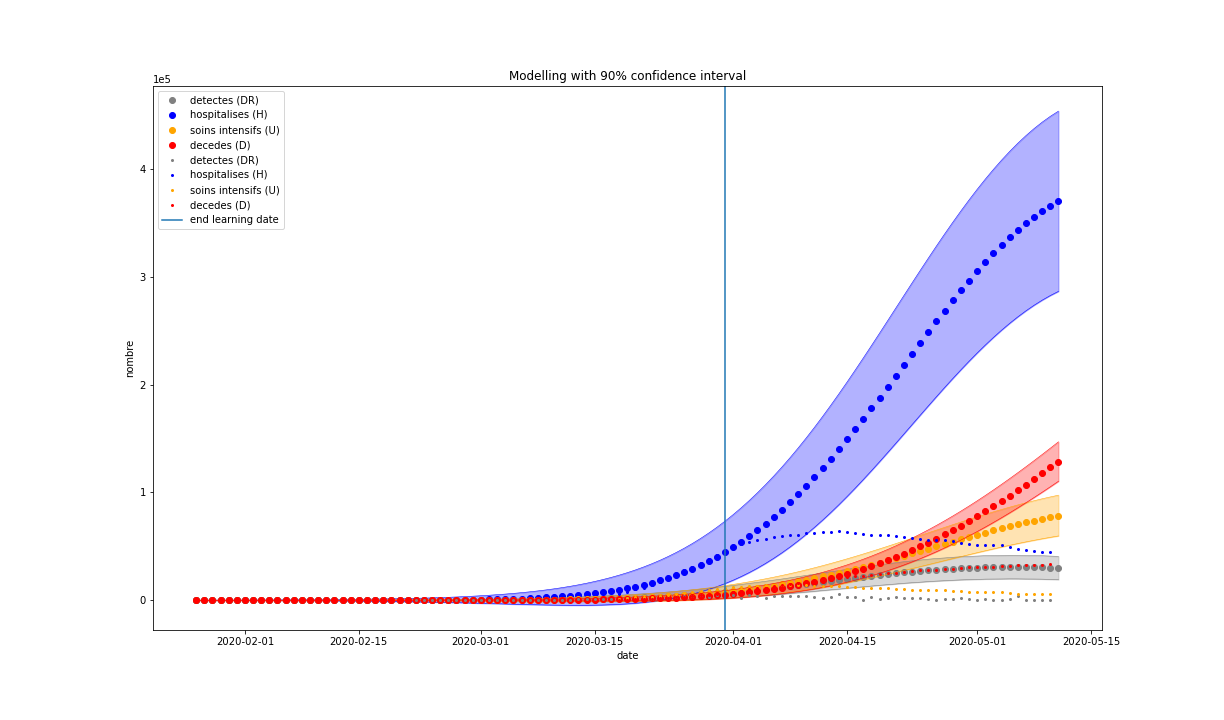

In [77]:
from IPython.display import Image
Image(filename="forecasting_first_learning_plug_in_uniform.png") 